# Analysis file for Ariane quantitative runs
gets data from .nc file into basic plot<br>
based on code from https://github.com/SalishSeaCast/analysis-susan/blob/master/notebooks/Ariane/FluxRobertsBankApr2015-New.ipynb

In [1]:
import cmocean.cm as cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import scipy.interpolate as interp
from scipy.stats import binned_statistic_2d

%matplotlib inline

### get grid info

In [2]:
mymesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

# Functions

In [5]:
def draw_patches(fmask, lonW, lonE, t_dist, t_depths): #draw ground part of cross section
    topo = []
    for i in range(lonW,lonE):
        for j in range(39):
            if fmask[j, i] == 0:
                rect = Rectangle((t_dist[i], t_depths[j]), t_dist[i+1]-t_dist[i], t_depths[j+1]-t_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='burlywood', edgecolors='burlywood', zorder=3)
    return(pc)

In [4]:
def TracerFluxCS(mydata, tracername, section, lonW, lonE, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = mydata.init_t[-1]
    
    lons = mydata.final_lon[(mydata.final_section==section)]
    lats = mydata.final_lat[(mydata.final_section==section)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section)]/time
    
    if tracername == 'salt' or tracername == 'silicon':
        tracer = mydata.init_salt[(mydata.final_section == section)]
        if tracername == 'salt':
            t_max = round(34 * 0.1,1)
            cmap = cm.haline
            units = 'g kg-1 m s-1'
        else:
            t_max = round(45 * 0.1,1)
            cmap = cm.matter
            units = 'mmol m-2 s-1'
    elif tracername == 'temp' or tracername == 'nitrate' or tracername == 'carbon':
        tracer = mydata.init_temp[(mydata.final_section == section)]
        if tracername == 'nitrate':
            t_max = round(30 * 0.1,1)
            cmap = cm.rain
            units = 'mmol m-2 s-1'
        else:
            t_max = round(2200 * 0.1,1)
            cmap = cm.turbid
            units = 'mmol m-2 s-1'
    else:
        print('incorrect tracer name, options are salt, temp, silicon, carbon, nitrate')
               
    H1, xedges1, yedges1 = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transports, density= True)# vmax=vmax)

    H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[lonW-1:lonE]), t_depths])
    _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[lonW-1:lonE]), t_depths])
       
    H_final = H1.T * H.statistic.T * float(sum(transports))
    np.nan_to_num(H_final, nan=0, copy=False)
    

    X, Y = np.meshgrid(xedges, yedges)
#     cmap = cm.haline
#     cmap.set_bad('grey', None)
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, vmin = 0, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, t_max]) 
    cb1.set_label(units, labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[lonW+1], t_dist[lonE-1], 5))
    ax.set_xticklabels(np.round(np.linspace(t_lons[lonW+1], t_lons[lonE-1], 5),2))
    ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
#     ax.set_title(str(title))
    mydata.close()

### Function specific for Deception

In [5]:
def DtracerFluxCS(mydata, tracername, section, latS, latN, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lat = mymesh.nav_lat[igrid]
    time = mydata.init_t[-1]
    
    lats = mydata.final_lat[(mydata.final_section==section)]
    
    t_lat = mymesh.gphit[0,:,igrid]
    m2lat = ((t_lat[latN]-t_lat[latS])/(mymesh.e2t[0, latS:latN, igrid].sum()))
    t_dist = t_lat/m2lat
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lats/m2lat
    depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section)]/time
    
    if tracername == 'salt' or tracername == 'silicon':
        tracer = mydata.init_salt[(mydata.final_section == section)]
        if tracername == 'salt':
            t_max = round(34 * 0.1,1)
            cmap = cm.haline
            units = 'g kg-1 m s-1'
        else:
            t_max = round(45 * 0.1,1)
            cmap = cm.matter
            units = 'mmol m-2 s-1'
    elif tracername == 'temp' or tracername == 'nitrate' or tracername == 'carbon':
        tracer = mydata.init_temp[(mydata.final_section == section)]
        if tracername == 'nitrate':
            t_max = round(30 * 0.1,1)
            cmap = cm.rain
            units = 'mmol m-2 s-1'
        else:
            t_max = round(2200 * 0.1,1)
            cmap = cm.turbid
            units = 'mmol m-2 s-1'
    else:
        print('incorrect tracer name, options are salt, temp, silicon, carbon, nitrate')

    H1, xedges1, yedges1 = np.histogram2d(dist, depths, bins=[np.array(t_dist[latS-1:latN+1]), t_depths],weights= transports, density= True)
    
    H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[latS-1:latN+1]), t_depths])
    _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[latS-1:latN+1]), t_depths])
    
    H_final = H1.T * H.statistic.T * float(sum(transports))
    np.nan_to_num(H_final, nan=0, copy=False)

    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, t_max])
    cb1.set_label(units, labelpad=-20)
    
    pc = draw_patches(fmask, latS-2, latN, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[latS-1], t_dist[latN], 2))
    ax.set_xticklabels(np.round(np.linspace(t_lat[latS-1], t_lat[latN], 2),2))
    ax.set_xlim((t_dist[latS-2], t_dist[latN]))
    ax.set_ylim((maxdepth, 0))
#     ax.set_title(str(title))
    mydata.close()

In [5]:
#lets make a fun lil matrix with all of the info we need about every channel to run the cross-section code
#in the format [section, jgridW, jgridE, figrid, maxdepth]
admiralty = [2, 255, 267, 204, 100]
rosario = [4, 286, 307, 266, 100]
sanjuan = [5, 264, 266, 280, 100]
haro = [6, 218, 242, 304, 300]

#in the format [section, jgridS, jgridN, figrid, maxdepth]
decep = [3, 246, 247, 309, 20]

# March
## Backwards run (source water, going from strait in title to the JDF)

In [7]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/backward_31mar19/ariane_positions_quantitative.nc'
file2 = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/backward_31mar19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
mydata2 = xr.open_dataset(file2)

Text(0.5, 1.0, 'Silica')

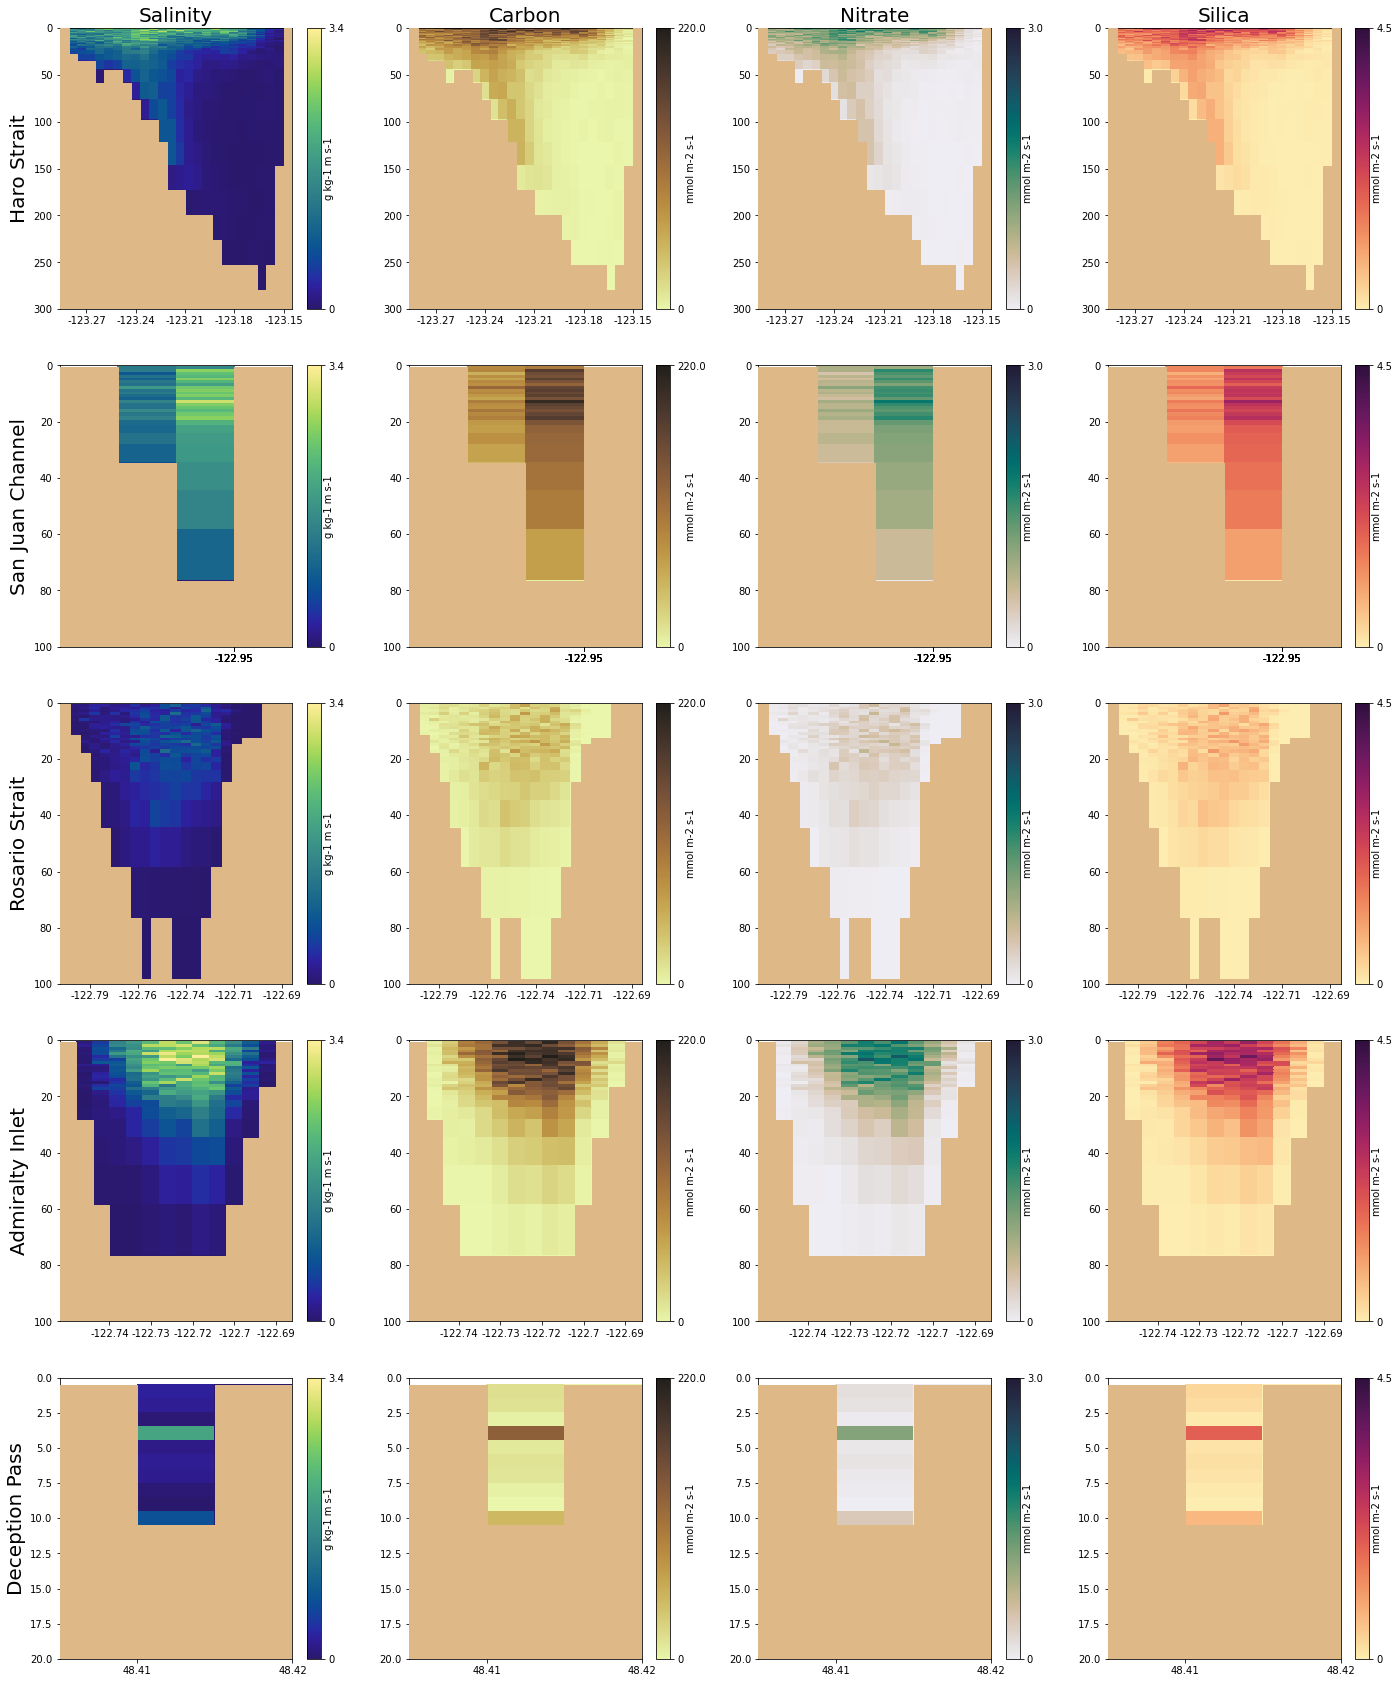

In [8]:
fig, axs = plt.subplots(5, 4, figsize = (24, 30))
TracerFluxCS(mydata, 'salt', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,0], "Haro Out, Salinity")
TracerFluxCS(mydata, 'carbon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,1], "Haro Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,2], "Haro Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,3], "Haro Out, Silicon")

TracerFluxCS(mydata, 'salt', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 0], "San Juan Out, Salinity")
TracerFluxCS(mydata, 'carbon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 1], "San Juan Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 2], "San Juan Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 3], "San Juan Out, Silicon")

TracerFluxCS(mydata, 'salt', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 0], "Rosario Out, Salinity")
TracerFluxCS(mydata, 'carbon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 1], "Rosario Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 2], "Rosario Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 3], "Rosario Out, Silicon")

TracerFluxCS(mydata, 'salt', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 0], "Admiralty Out, Salinity")
TracerFluxCS(mydata, 'carbon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 1], "Admiralty Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 2], "Admiralty Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 3], "Admiralty Out, Silicon")

DtracerFluxCS(mydata, 'salt', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,0], "Deception Out, Salinity")
DtracerFluxCS(mydata, 'carbon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,1], "Deception Out, Carbon")
DtracerFluxCS(mydata2, 'nitrate', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,2], "Deception Out, Nitrate")
DtracerFluxCS(mydata2, 'silicon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,3], "Deception Out, Silicon")

axs[0,0].set_ylabel('Haro Strait', fontsize = 20)
axs[1,0].set_ylabel('San Juan Channel', fontsize = 20)
axs[2,0].set_ylabel('Rosario Strait', fontsize = 20)
axs[3,0].set_ylabel('Admiralty Inlet', fontsize = 20)
axs[4,0].set_ylabel('Deception Pass', fontsize = 20)
axs[0,0].set_title('Salinity', fontsize = 20)
axs[0,1].set_title('Carbon', fontsize = 20)
axs[0,2].set_title('Nitrate', fontsize = 20)
axs[0,3].set_title('Silica', fontsize = 20)

## Forwards run (from JDF to these straits)

In [9]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01mar19/ariane_positions_quantitative.nc'
file2 = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01mar19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
mydata2 = xr.open_dataset(file2)

Text(0.5, 1.0, 'Silica')

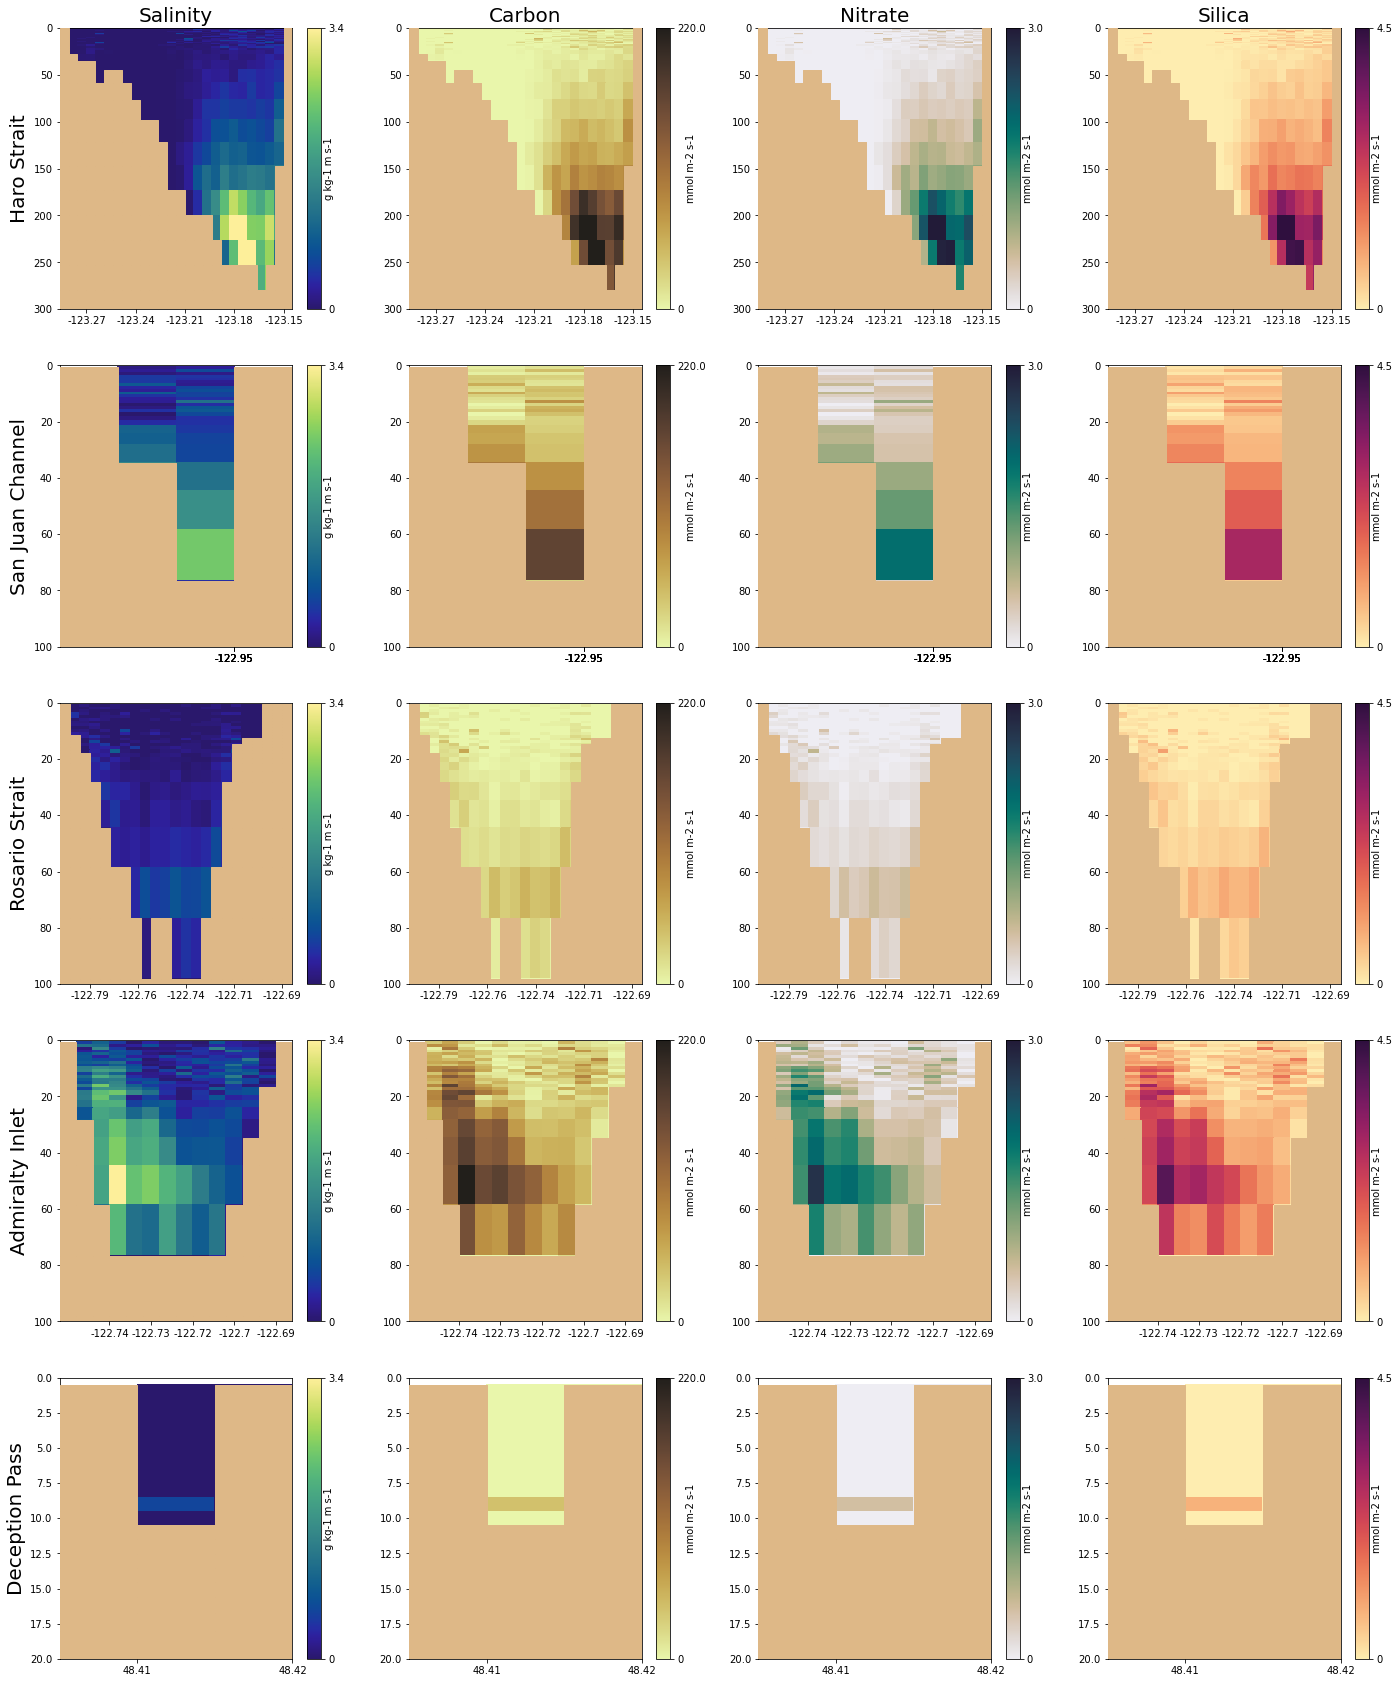

In [10]:
fig, axs = plt.subplots(5, 4, figsize = (24, 30))
TracerFluxCS(mydata, 'salt', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,0], "Haro In, Salinity")
TracerFluxCS(mydata, 'carbon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,1], "Haro In, Carbon")
TracerFluxCS(mydata2, 'nitrate', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,2], "Haro In, Nitrate")
TracerFluxCS(mydata2, 'silicon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,3], "Haro In, Silicon")

TracerFluxCS(mydata, 'salt', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 0], "San Juan In, Salinity")
TracerFluxCS(mydata, 'carbon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 1], "San Juan In, Carbon")
TracerFluxCS(mydata2, 'nitrate', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 2], "San Juan In, Nitrate")
TracerFluxCS(mydata2, 'silicon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 3], "San Juan In, Silicon")

TracerFluxCS(mydata, 'salt', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 0], "Rosario In, Salinity")
TracerFluxCS(mydata, 'carbon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 1], "Rosario In, Carbon")
TracerFluxCS(mydata2, 'nitrate', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 2], "Rosario In, Nitrate")
TracerFluxCS(mydata2, 'silicon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 3], "Rosario In, Silicon")

TracerFluxCS(mydata, 'salt', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 0], "Admiralty In, Salinity")
TracerFluxCS(mydata, 'carbon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 1], "Admiralty In, Carbon")
TracerFluxCS(mydata2, 'nitrate', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 2], "Admiralty In, Nitrate")
TracerFluxCS(mydata2, 'silicon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 3], "Admiralty In, Silicon")

DtracerFluxCS(mydata, 'salt', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,0], "Deception In, Salinity")
DtracerFluxCS(mydata, 'carbon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,1], "Deception In, Carbon")
DtracerFluxCS(mydata2, 'nitrate', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,2], "Deception In, Nitrate")
DtracerFluxCS(mydata2, 'silicon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,3], "Deception In, Silicon")

axs[0,0].set_ylabel('Haro Strait', fontsize = 20)
axs[1,0].set_ylabel('San Juan Channel', fontsize = 20)
axs[2,0].set_ylabel('Rosario Strait', fontsize = 20)
axs[3,0].set_ylabel('Admiralty Inlet', fontsize = 20)
axs[4,0].set_ylabel('Deception Pass', fontsize = 20)
axs[0,0].set_title('Salinity', fontsize = 20)
axs[0,1].set_title('Carbon', fontsize = 20)
axs[0,2].set_title('Nitrate', fontsize = 20)
axs[0,3].set_title('Silica', fontsize = 20)

# June
## Backwards run (source water, going from strait in title to the JDF)

In [11]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/backward_01jul19/ariane_positions_quantitative.nc'
file2 = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/backward_01jul19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
mydata2 = xr.open_dataset(file2)

Text(0.5, 1.0, 'Silica')

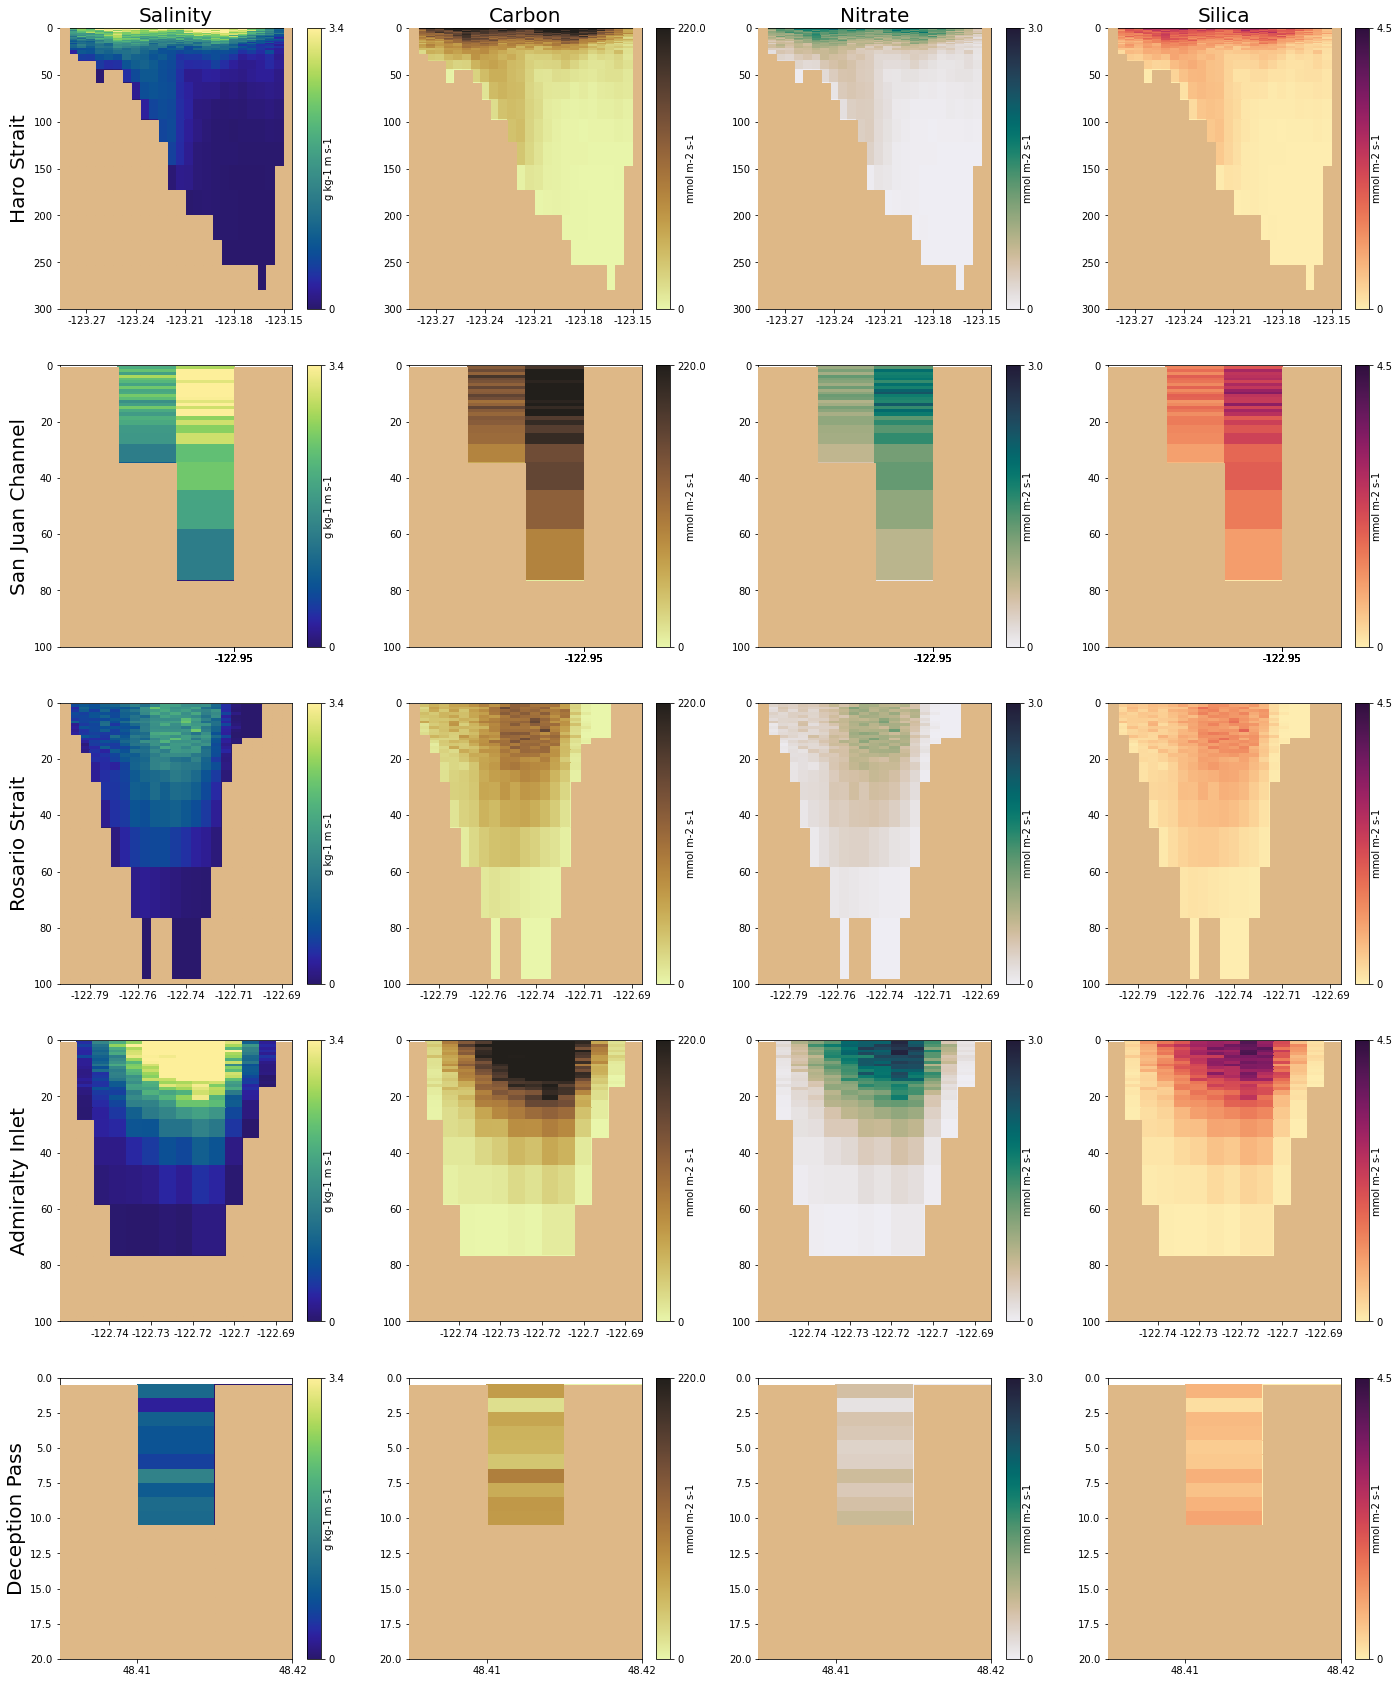

In [12]:
fig, axs = plt.subplots(5, 4, figsize = (24, 30))
TracerFluxCS(mydata, 'salt', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,0], "Haro Out, Salinity")
TracerFluxCS(mydata, 'carbon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,1], "Haro Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,2], "Haro Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,3], "Haro Out, Silicon")

TracerFluxCS(mydata, 'salt', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 0], "San Juan Out, Salinity")
TracerFluxCS(mydata, 'carbon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 1], "San Juan Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 2], "San Juan Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 3], "San Juan Out, Silicon")

TracerFluxCS(mydata, 'salt', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 0], "Rosario Out, Salinity")
TracerFluxCS(mydata, 'carbon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 1], "Rosario Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 2], "Rosario Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 3], "Rosario Out, Silicon")

TracerFluxCS(mydata, 'salt', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 0], "Admiralty Out, Salinity")
TracerFluxCS(mydata, 'carbon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 1], "Admiralty Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 2], "Admiralty Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 3], "Admiralty Out, Silicon")

DtracerFluxCS(mydata, 'salt', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,0], "Deception Out, Salinity")
DtracerFluxCS(mydata, 'carbon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,1], "Deception Out, Carbon")
DtracerFluxCS(mydata2, 'nitrate', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,2], "Deception Out, Nitrate")
DtracerFluxCS(mydata2, 'silicon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,3], "Deception Out, Silicon")

axs[0,0].set_ylabel('Haro Strait', fontsize = 20)
axs[1,0].set_ylabel('San Juan Channel', fontsize = 20)
axs[2,0].set_ylabel('Rosario Strait', fontsize = 20)
axs[3,0].set_ylabel('Admiralty Inlet', fontsize = 20)
axs[4,0].set_ylabel('Deception Pass', fontsize = 20)
axs[0,0].set_title('Salinity', fontsize = 20)
axs[0,1].set_title('Carbon', fontsize = 20)
axs[0,2].set_title('Nitrate', fontsize = 20)
axs[0,3].set_title('Silica', fontsize = 20)

## Forwards run (from JDF to these straits)

In [13]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01jun19/ariane_positions_quantitative.nc'
file2 = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01jun19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
mydata2 = xr.open_dataset(file2)

Text(0.5, 1.0, 'Silica')

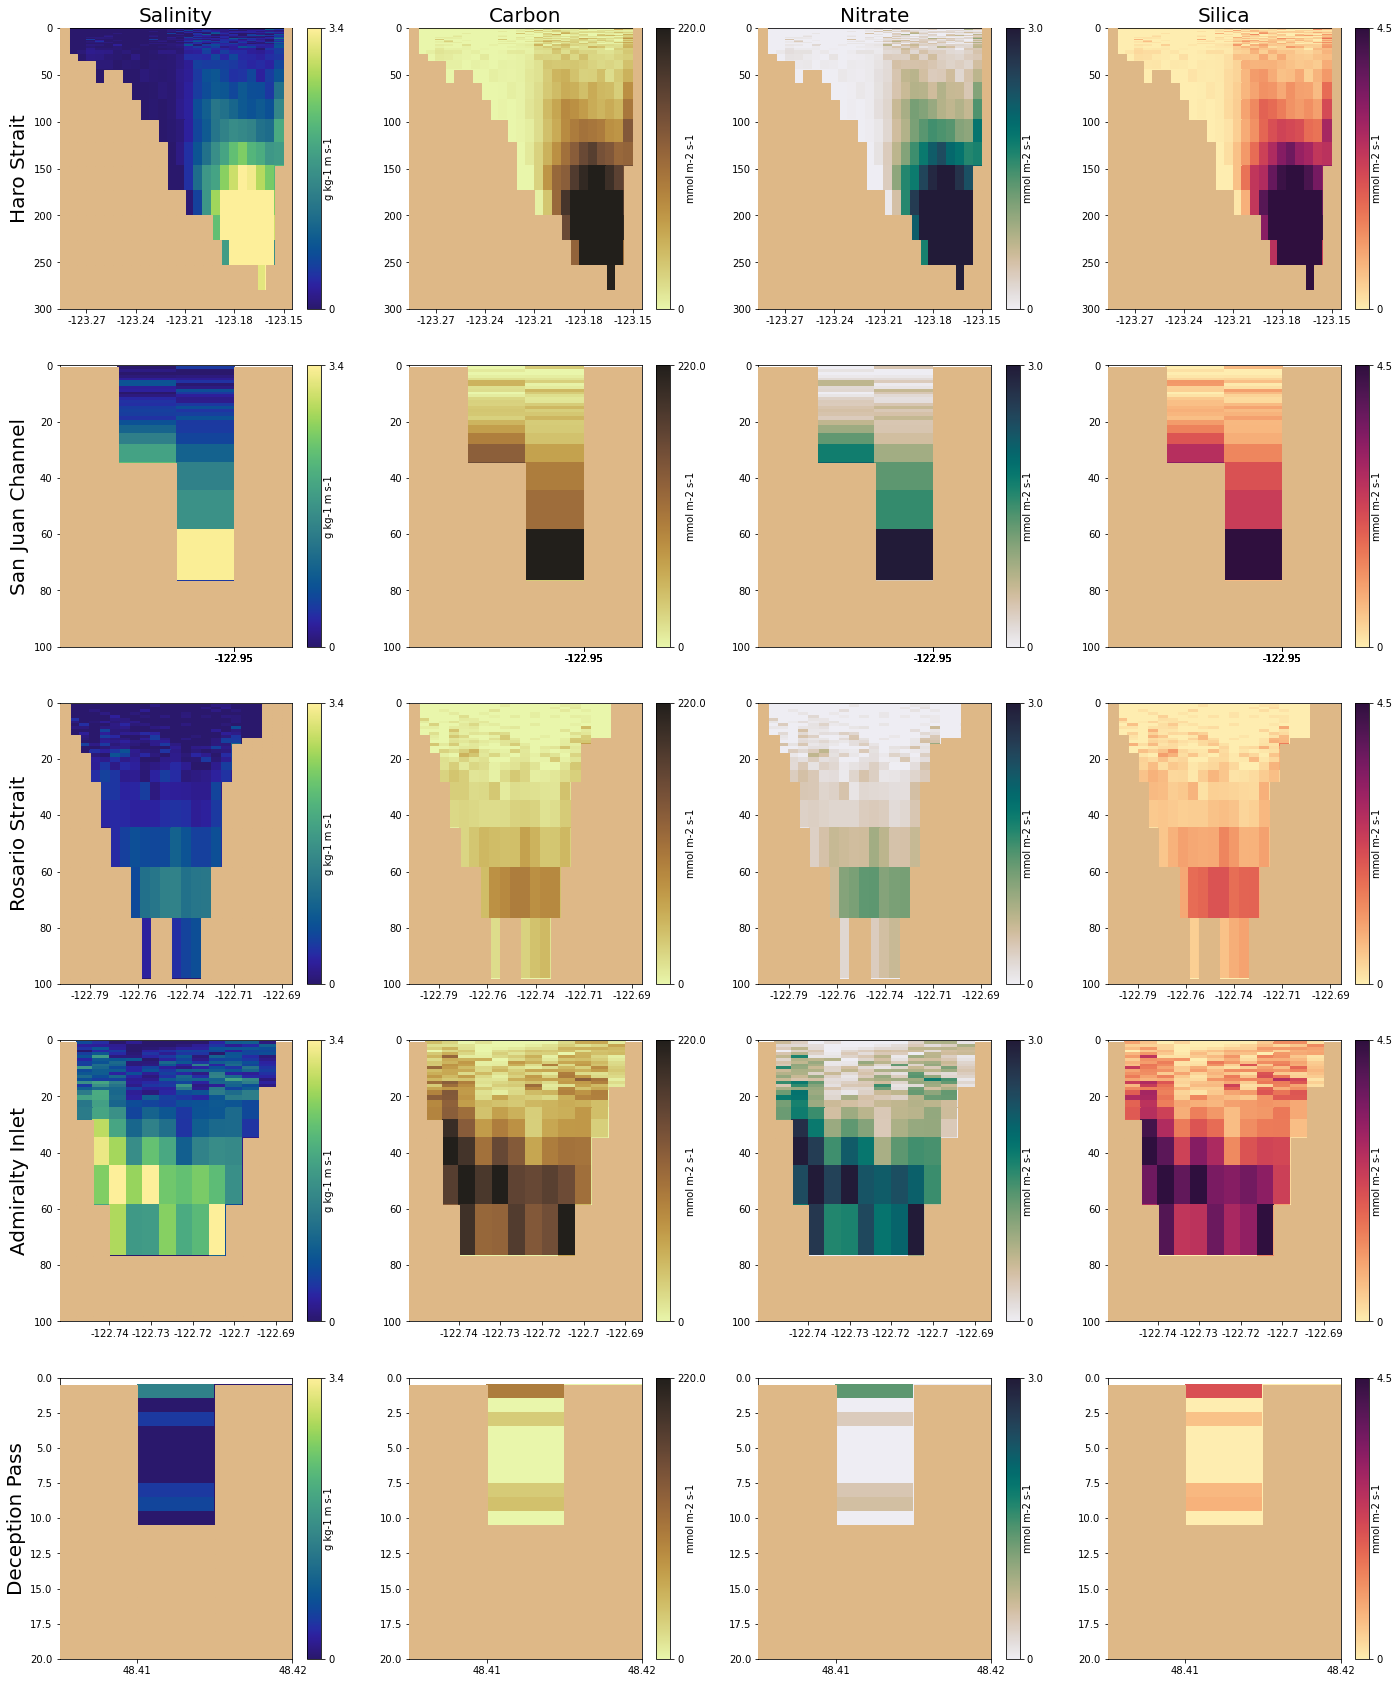

In [14]:
fig, axs = plt.subplots(5, 4, figsize = (24, 30))
TracerFluxCS(mydata, 'salt', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,0], "Haro In, Salinity")
TracerFluxCS(mydata, 'carbon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,1], "Haro In, Carbon")
TracerFluxCS(mydata2, 'nitrate', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,2], "Haro In, Nitrate")
TracerFluxCS(mydata2, 'silicon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,3], "Haro In, Silicon")

TracerFluxCS(mydata, 'salt', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 0], "San Juan In, Salinity")
TracerFluxCS(mydata, 'carbon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 1], "San Juan In, Carbon")
TracerFluxCS(mydata2, 'nitrate', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 2], "San Juan In, Nitrate")
TracerFluxCS(mydata2, 'silicon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 3], "San Juan In, Silicon")

TracerFluxCS(mydata, 'salt', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 0], "Rosario In, Salinity")
TracerFluxCS(mydata, 'carbon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 1], "Rosario In, Carbon")
TracerFluxCS(mydata2, 'nitrate', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 2], "Rosario In, Nitrate")
TracerFluxCS(mydata2, 'silicon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 3], "Rosario In, Silicon")

TracerFluxCS(mydata, 'salt', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 0], "Admiralty In, Salinity")
TracerFluxCS(mydata, 'carbon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 1], "Admiralty In, Carbon")
TracerFluxCS(mydata2, 'nitrate', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 2], "Admiralty In, Nitrate")
TracerFluxCS(mydata2, 'silicon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 3], "Admiralty In, Silicon")

DtracerFluxCS(mydata, 'salt', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,0], "Deception In, Salinity")
DtracerFluxCS(mydata, 'carbon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,1], "Deception In, Carbon")
DtracerFluxCS(mydata2, 'nitrate', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,2], "Deception In, Nitrate")
DtracerFluxCS(mydata2, 'silicon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,3], "Deception In, Silicon")

axs[0,0].set_ylabel('Haro Strait', fontsize = 20)
axs[1,0].set_ylabel('San Juan Channel', fontsize = 20)
axs[2,0].set_ylabel('Rosario Strait', fontsize = 20)
axs[3,0].set_ylabel('Admiralty Inlet', fontsize = 20)
axs[4,0].set_ylabel('Deception Pass', fontsize = 20)
axs[0,0].set_title('Salinity', fontsize = 20)
axs[0,1].set_title('Carbon', fontsize = 20)
axs[0,2].set_title('Nitrate', fontsize = 20)
axs[0,3].set_title('Silica', fontsize = 20)

# September
## Backwards run (source water, going from strait in title to the JDF)

In [15]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/backward_01oct19/ariane_positions_quantitative.nc'
file2 = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/backward_01oct19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
mydata2 = xr.open_dataset(file2)

Text(0.5, 1.0, 'Silica')

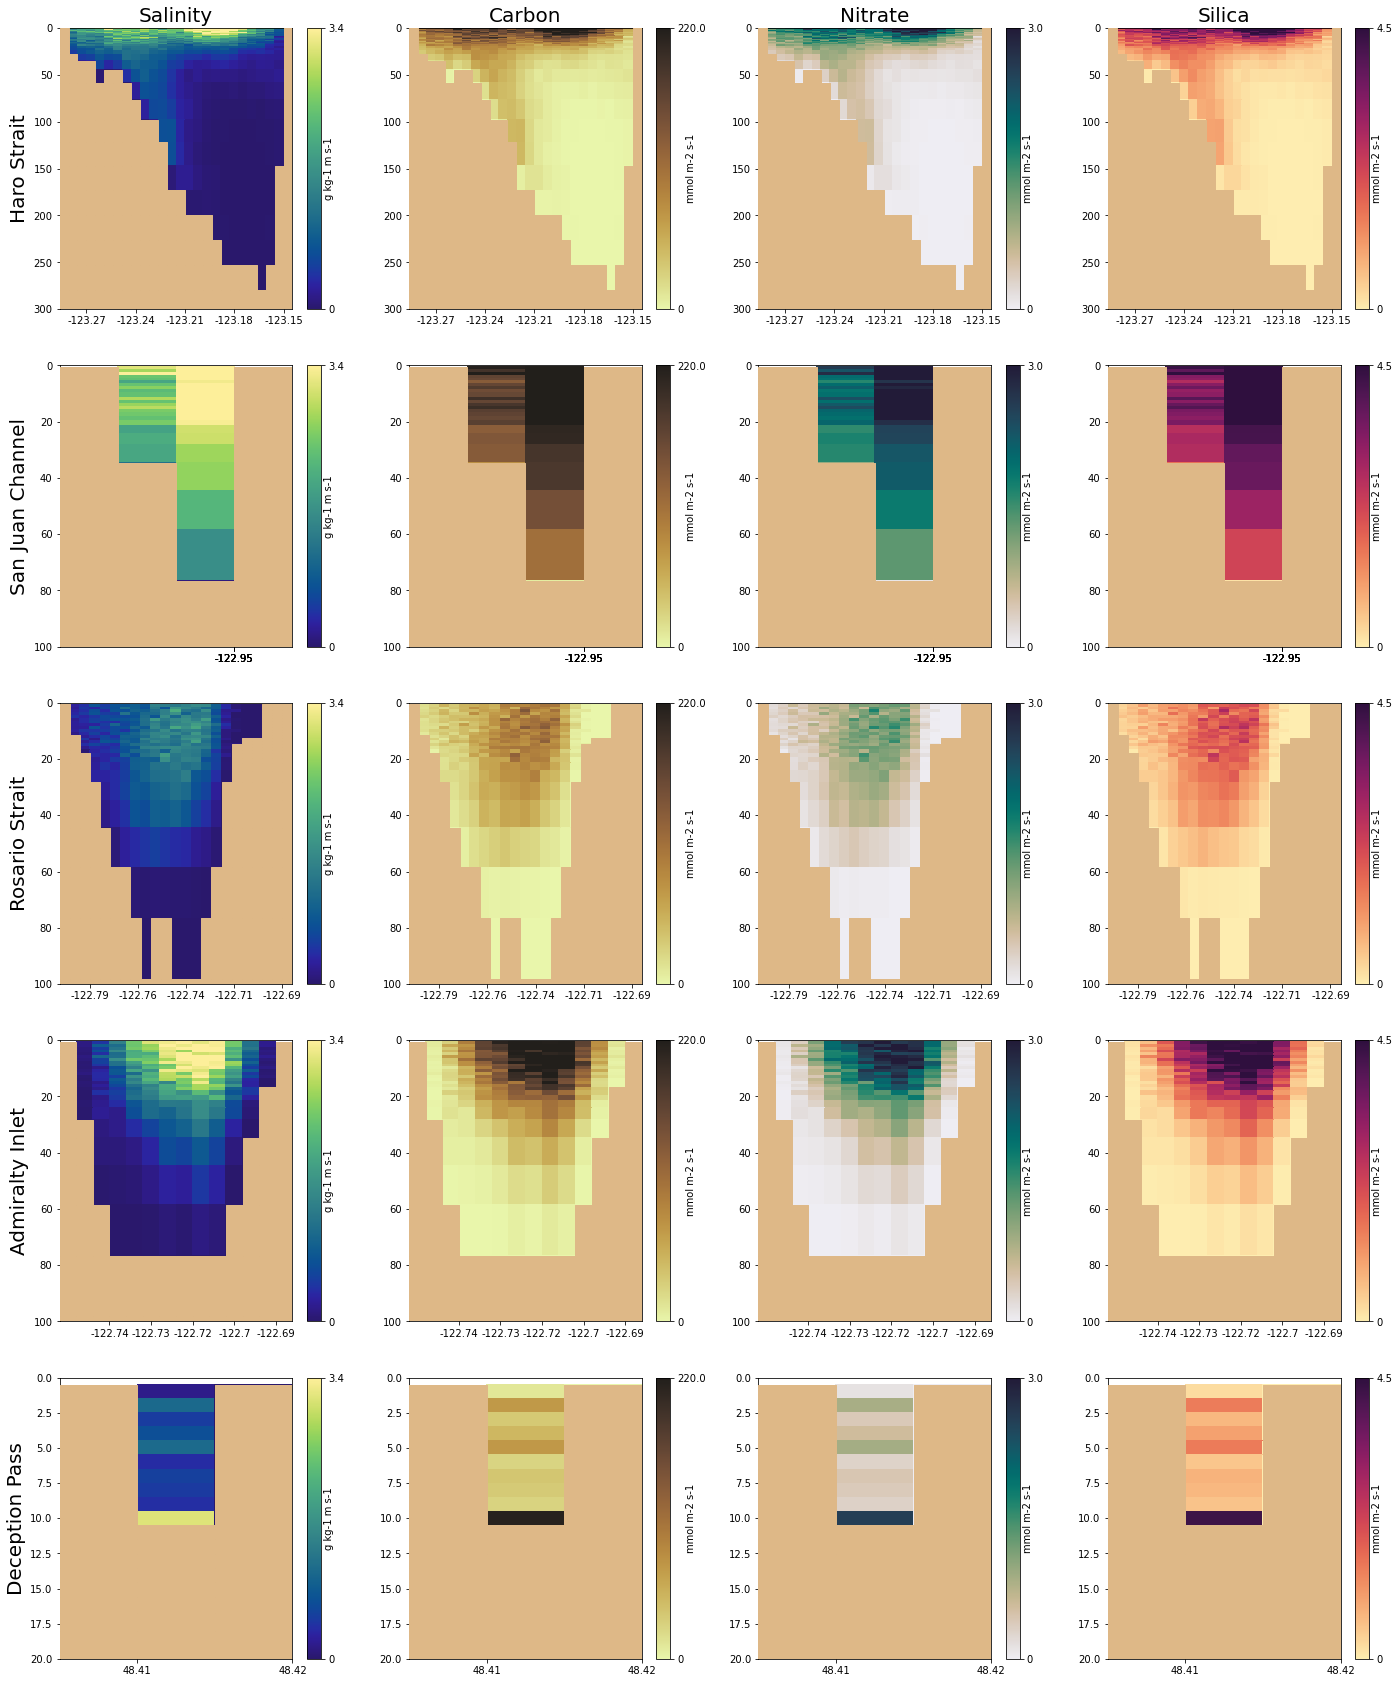

In [16]:
fig, axs = plt.subplots(5, 4, figsize = (24, 30))
TracerFluxCS(mydata, 'salt', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,0], "Haro Out, Salinity")
TracerFluxCS(mydata, 'carbon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,1], "Haro Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,2], "Haro Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,3], "Haro Out, Silicon")

TracerFluxCS(mydata, 'salt', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 0], "San Juan Out, Salinity")
TracerFluxCS(mydata, 'carbon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 1], "San Juan Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 2], "San Juan Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 3], "San Juan Out, Silicon")

TracerFluxCS(mydata, 'salt', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 0], "Rosario Out, Salinity")
TracerFluxCS(mydata, 'carbon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 1], "Rosario Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 2], "Rosario Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 3], "Rosario Out, Silicon")

TracerFluxCS(mydata, 'salt', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 0], "Admiralty Out, Salinity")
TracerFluxCS(mydata, 'carbon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 1], "Admiralty Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 2], "Admiralty Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 3], "Admiralty Out, Silicon")

DtracerFluxCS(mydata, 'salt', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,0], "Deception Out, Salinity")
DtracerFluxCS(mydata, 'carbon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,1], "Deception Out, Carbon")
DtracerFluxCS(mydata2, 'nitrate', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,2], "Deception Out, Nitrate")
DtracerFluxCS(mydata2, 'silicon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,3], "Deception Out, Silicon")

axs[0,0].set_ylabel('Haro Strait', fontsize = 20)
axs[1,0].set_ylabel('San Juan Channel', fontsize = 20)
axs[2,0].set_ylabel('Rosario Strait', fontsize = 20)
axs[3,0].set_ylabel('Admiralty Inlet', fontsize = 20)
axs[4,0].set_ylabel('Deception Pass', fontsize = 20)
axs[0,0].set_title('Salinity', fontsize = 20)
axs[0,1].set_title('Carbon', fontsize = 20)
axs[0,2].set_title('Nitrate', fontsize = 20)
axs[0,3].set_title('Silica', fontsize = 20)

## Forwards run (from JDF to these straits)

In [17]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01sep19/ariane_positions_quantitative.nc'
file2 = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01sep19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
mydata2 = xr.open_dataset(file2)

Text(0.5, 1.0, 'Silica')

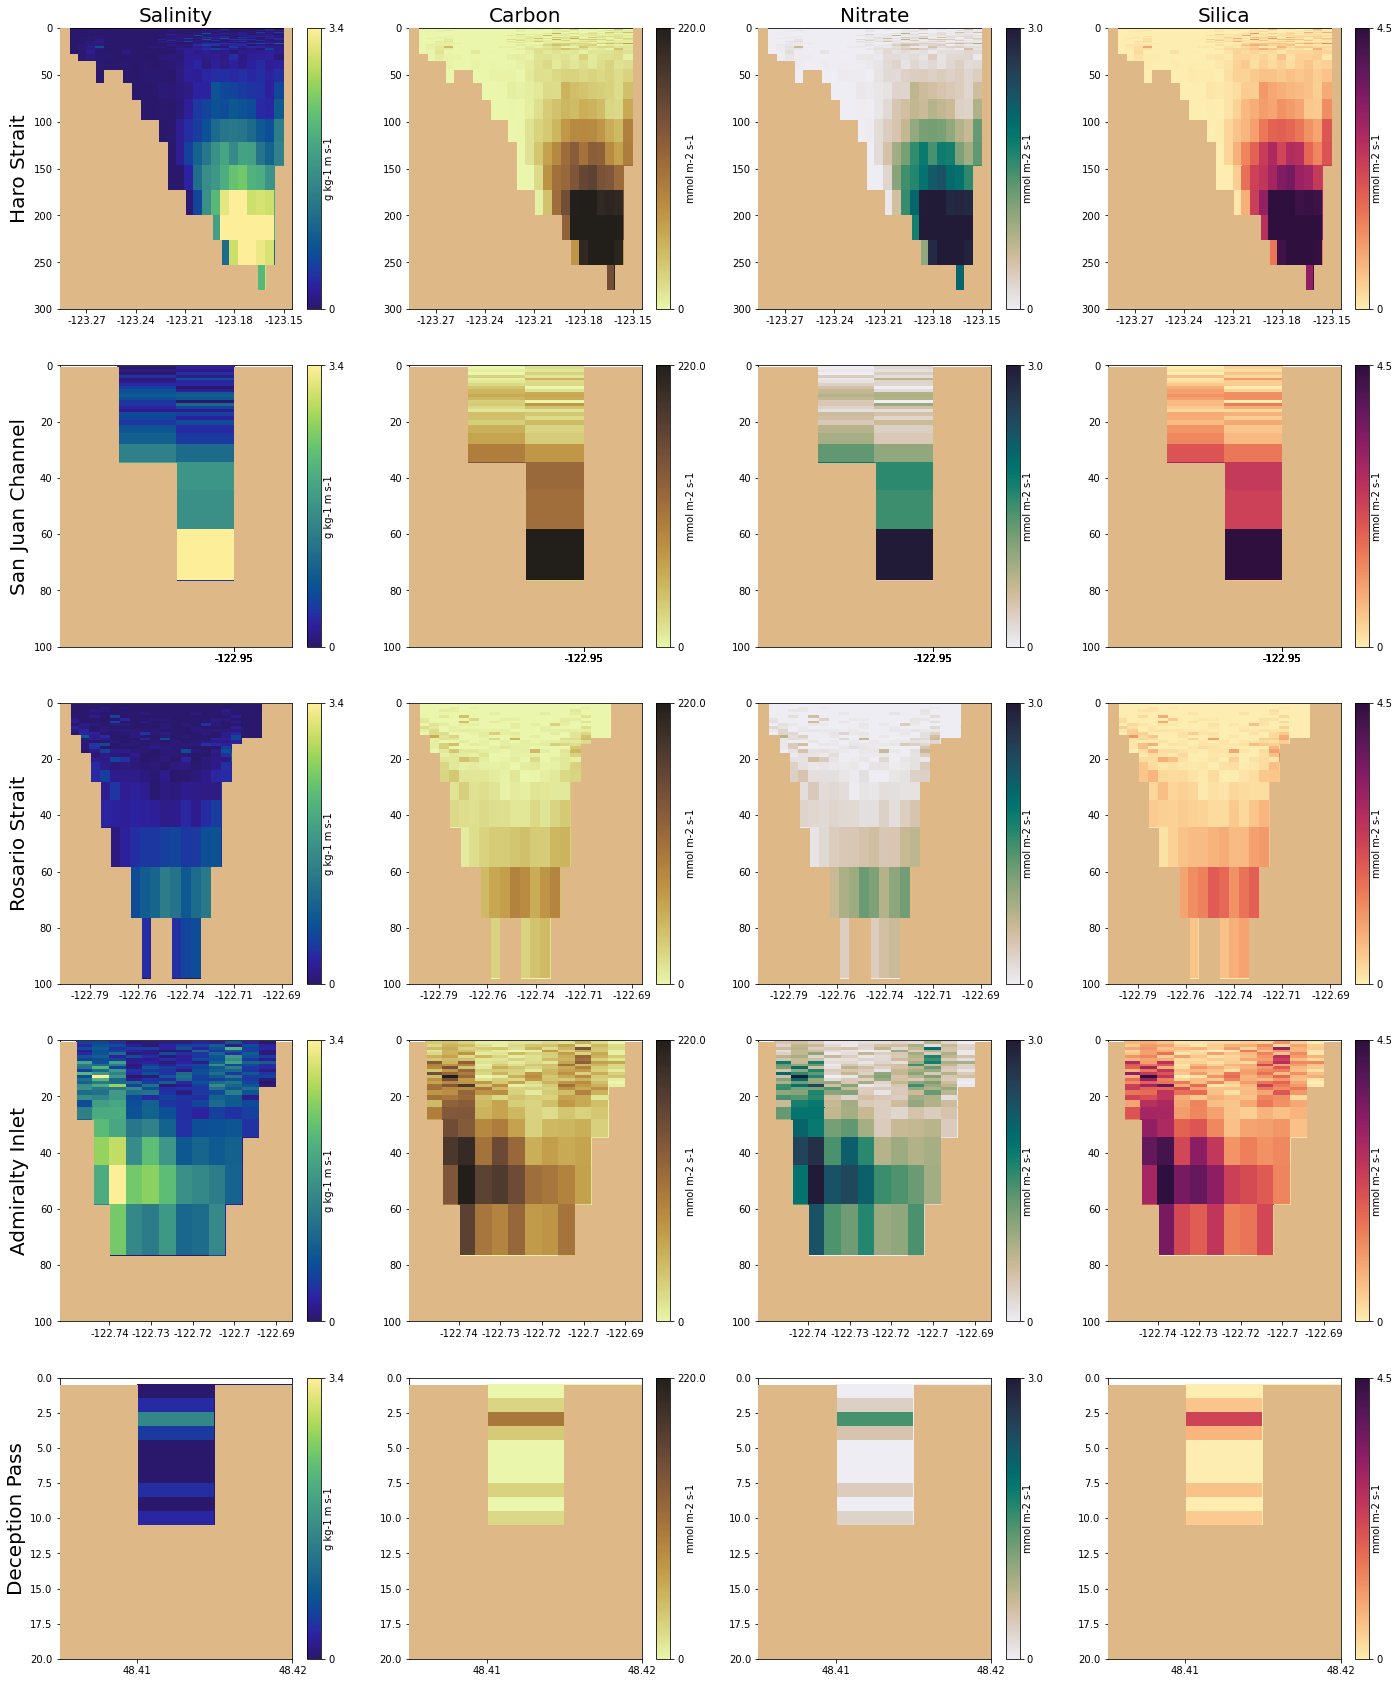

In [18]:
fig, axs = plt.subplots(5, 4, figsize = (24, 30))
TracerFluxCS(mydata, 'salt', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,0], "Haro In, Salinity")
TracerFluxCS(mydata, 'carbon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,1], "Haro In, Carbon")
TracerFluxCS(mydata2, 'nitrate', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,2], "Haro In, Nitrate")
TracerFluxCS(mydata2, 'silicon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,3], "Haro In, Silicon")

TracerFluxCS(mydata, 'salt', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 0], "San Juan In, Salinity")
TracerFluxCS(mydata, 'carbon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 1], "San Juan In, Carbon")
TracerFluxCS(mydata2, 'nitrate', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 2], "San Juan In, Nitrate")
TracerFluxCS(mydata2, 'silicon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 3], "San Juan In, Silicon")

TracerFluxCS(mydata, 'salt', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 0], "Rosario In, Salinity")
TracerFluxCS(mydata, 'carbon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 1], "Rosario In, Carbon")
TracerFluxCS(mydata2, 'nitrate', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 2], "Rosario In, Nitrate")
TracerFluxCS(mydata2, 'silicon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 3], "Rosario In, Silicon")

TracerFluxCS(mydata, 'salt', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 0], "Admiralty In, Salinity")
TracerFluxCS(mydata, 'carbon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 1], "Admiralty In, Carbon")
TracerFluxCS(mydata2, 'nitrate', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 2], "Admiralty In, Nitrate")
TracerFluxCS(mydata2, 'silicon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 3], "Admiralty In, Silicon")

DtracerFluxCS(mydata, 'salt', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,0], "Deception In, Salinity")
DtracerFluxCS(mydata, 'carbon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,1], "Deception In, Carbon")
DtracerFluxCS(mydata2, 'nitrate', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,2], "Deception In, Nitrate")
DtracerFluxCS(mydata2, 'silicon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,3], "Deception In, Silicon")

axs[0,0].set_ylabel('Haro Strait', fontsize = 20)
axs[1,0].set_ylabel('San Juan Channel', fontsize = 20)
axs[2,0].set_ylabel('Rosario Strait', fontsize = 20)
axs[3,0].set_ylabel('Admiralty Inlet', fontsize = 20)
axs[4,0].set_ylabel('Deception Pass', fontsize = 20)
axs[0,0].set_title('Salinity', fontsize = 20)
axs[0,1].set_title('Carbon', fontsize = 20)
axs[0,2].set_title('Nitrate', fontsize = 20)
axs[0,3].set_title('Silica', fontsize = 20)

# December
## Backwards run (source water, going from strait in title to the JDF)

In [19]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/backward_31dec19/ariane_positions_quantitative.nc'
file2 = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/backward_31dec19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
mydata2 = xr.open_dataset(file2)

Text(0.5, 1.0, 'Silica')

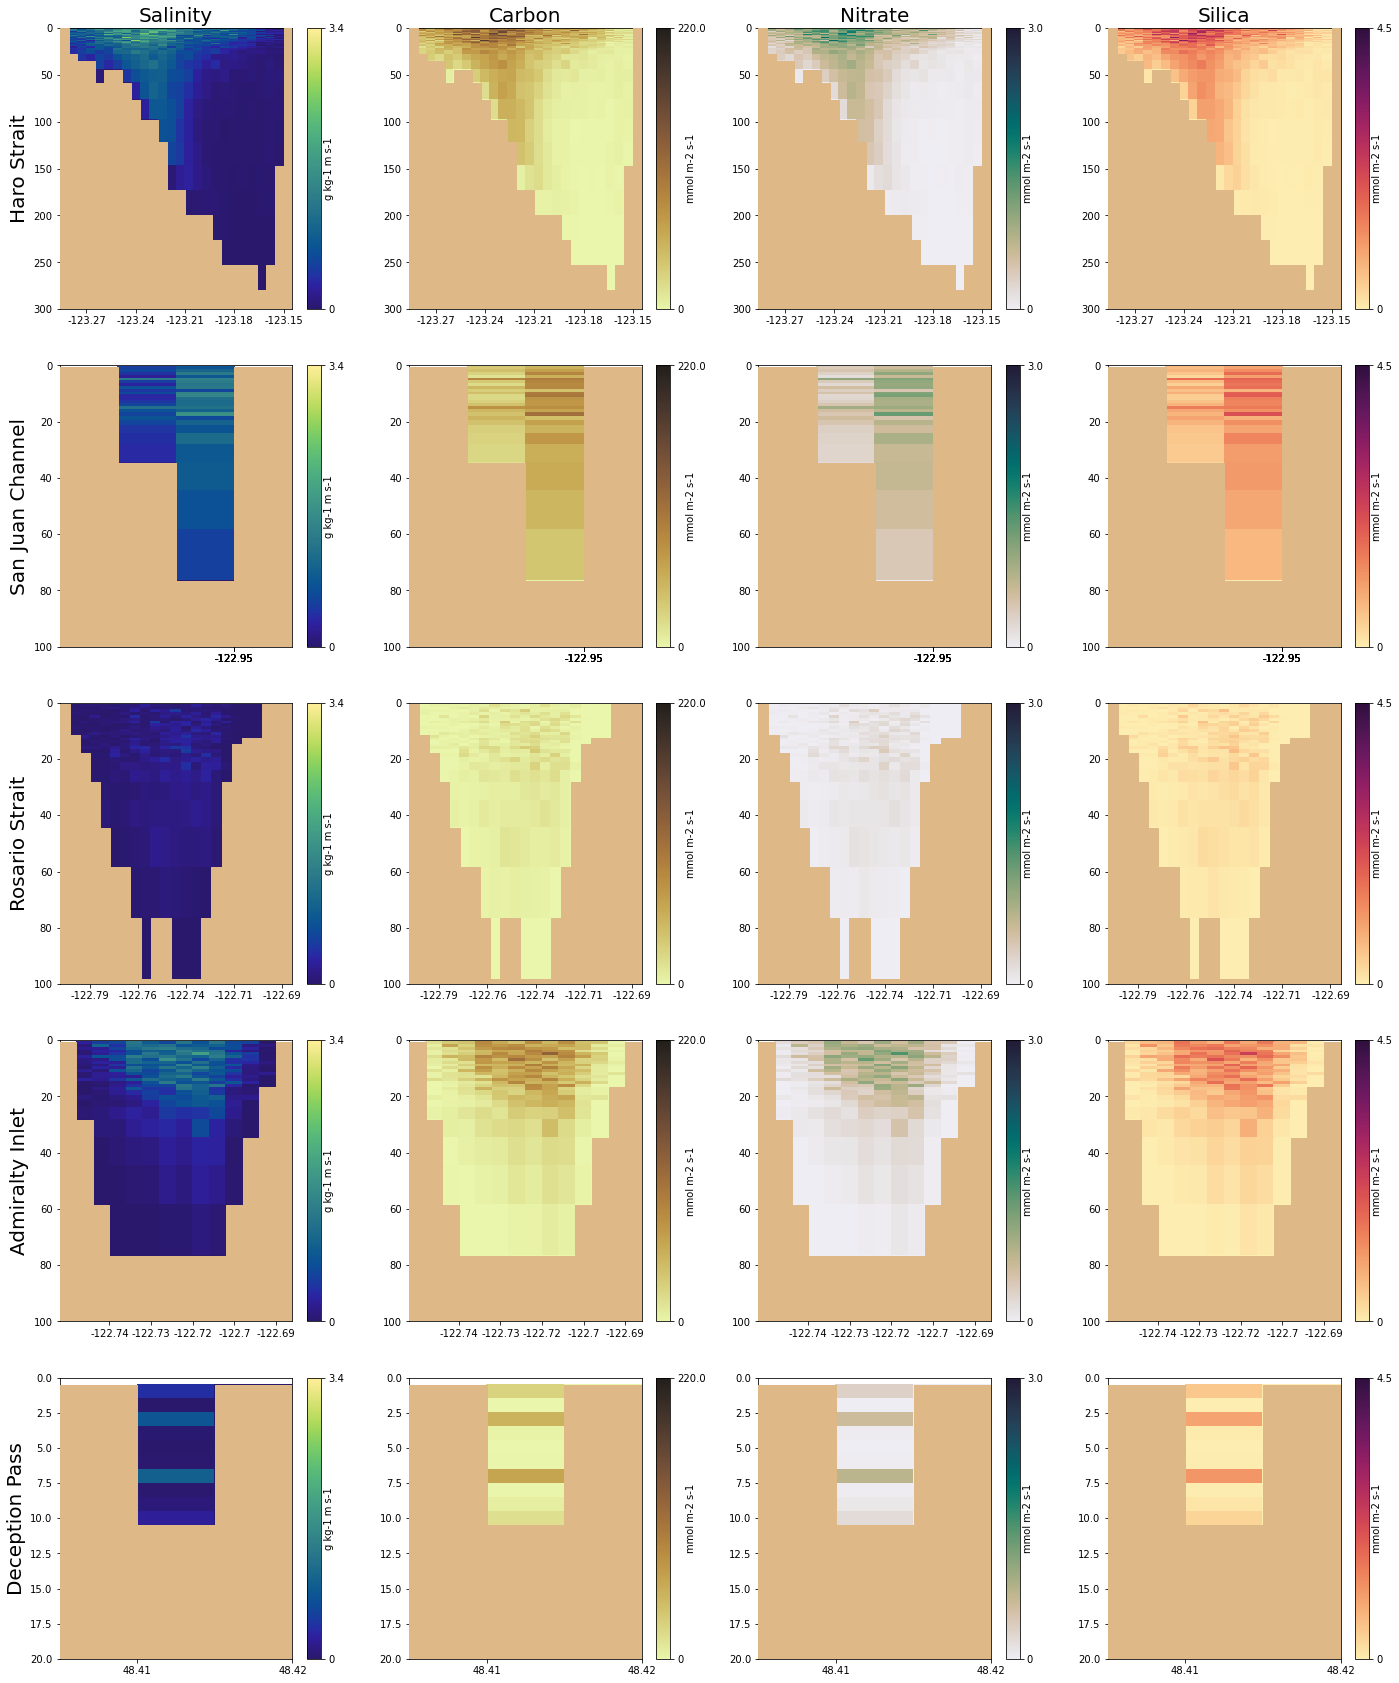

In [20]:
fig, axs = plt.subplots(5, 4, figsize = (24, 30))
TracerFluxCS(mydata, 'salt', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,0], "Haro Out, Salinity")
TracerFluxCS(mydata, 'carbon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,1], "Haro Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,2], "Haro Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,3], "Haro Out, Silicon")

TracerFluxCS(mydata, 'salt', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 0], "San Juan Out, Salinity")
TracerFluxCS(mydata, 'carbon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 1], "San Juan Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 2], "San Juan Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 3], "San Juan Out, Silicon")

TracerFluxCS(mydata, 'salt', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 0], "Rosario Out, Salinity")
TracerFluxCS(mydata, 'carbon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 1], "Rosario Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 2], "Rosario Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 3], "Rosario Out, Silicon")

TracerFluxCS(mydata, 'salt', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 0], "Admiralty Out, Salinity")
TracerFluxCS(mydata, 'carbon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 1], "Admiralty Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 2], "Admiralty Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 3], "Admiralty Out, Silicon")

DtracerFluxCS(mydata, 'salt', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,0], "Deception Out, Salinity")
DtracerFluxCS(mydata, 'carbon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,1], "Deception Out, Carbon")
DtracerFluxCS(mydata2, 'nitrate', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,2], "Deception Out, Nitrate")
DtracerFluxCS(mydata2, 'silicon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,3], "Deception Out, Silicon")

axs[0,0].set_ylabel('Haro Strait', fontsize = 20)
axs[1,0].set_ylabel('San Juan Channel', fontsize = 20)
axs[2,0].set_ylabel('Rosario Strait', fontsize = 20)
axs[3,0].set_ylabel('Admiralty Inlet', fontsize = 20)
axs[4,0].set_ylabel('Deception Pass', fontsize = 20)
axs[0,0].set_title('Salinity', fontsize = 20)
axs[0,1].set_title('Carbon', fontsize = 20)
axs[0,2].set_title('Nitrate', fontsize = 20)
axs[0,3].set_title('Silica', fontsize = 20)

## Forwards run (from JDF to these straits)

In [21]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01dec19/ariane_positions_quantitative.nc'
file2 = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01dec19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
mydata2 = xr.open_dataset(file2)

Text(0.5, 1.0, 'Silica')

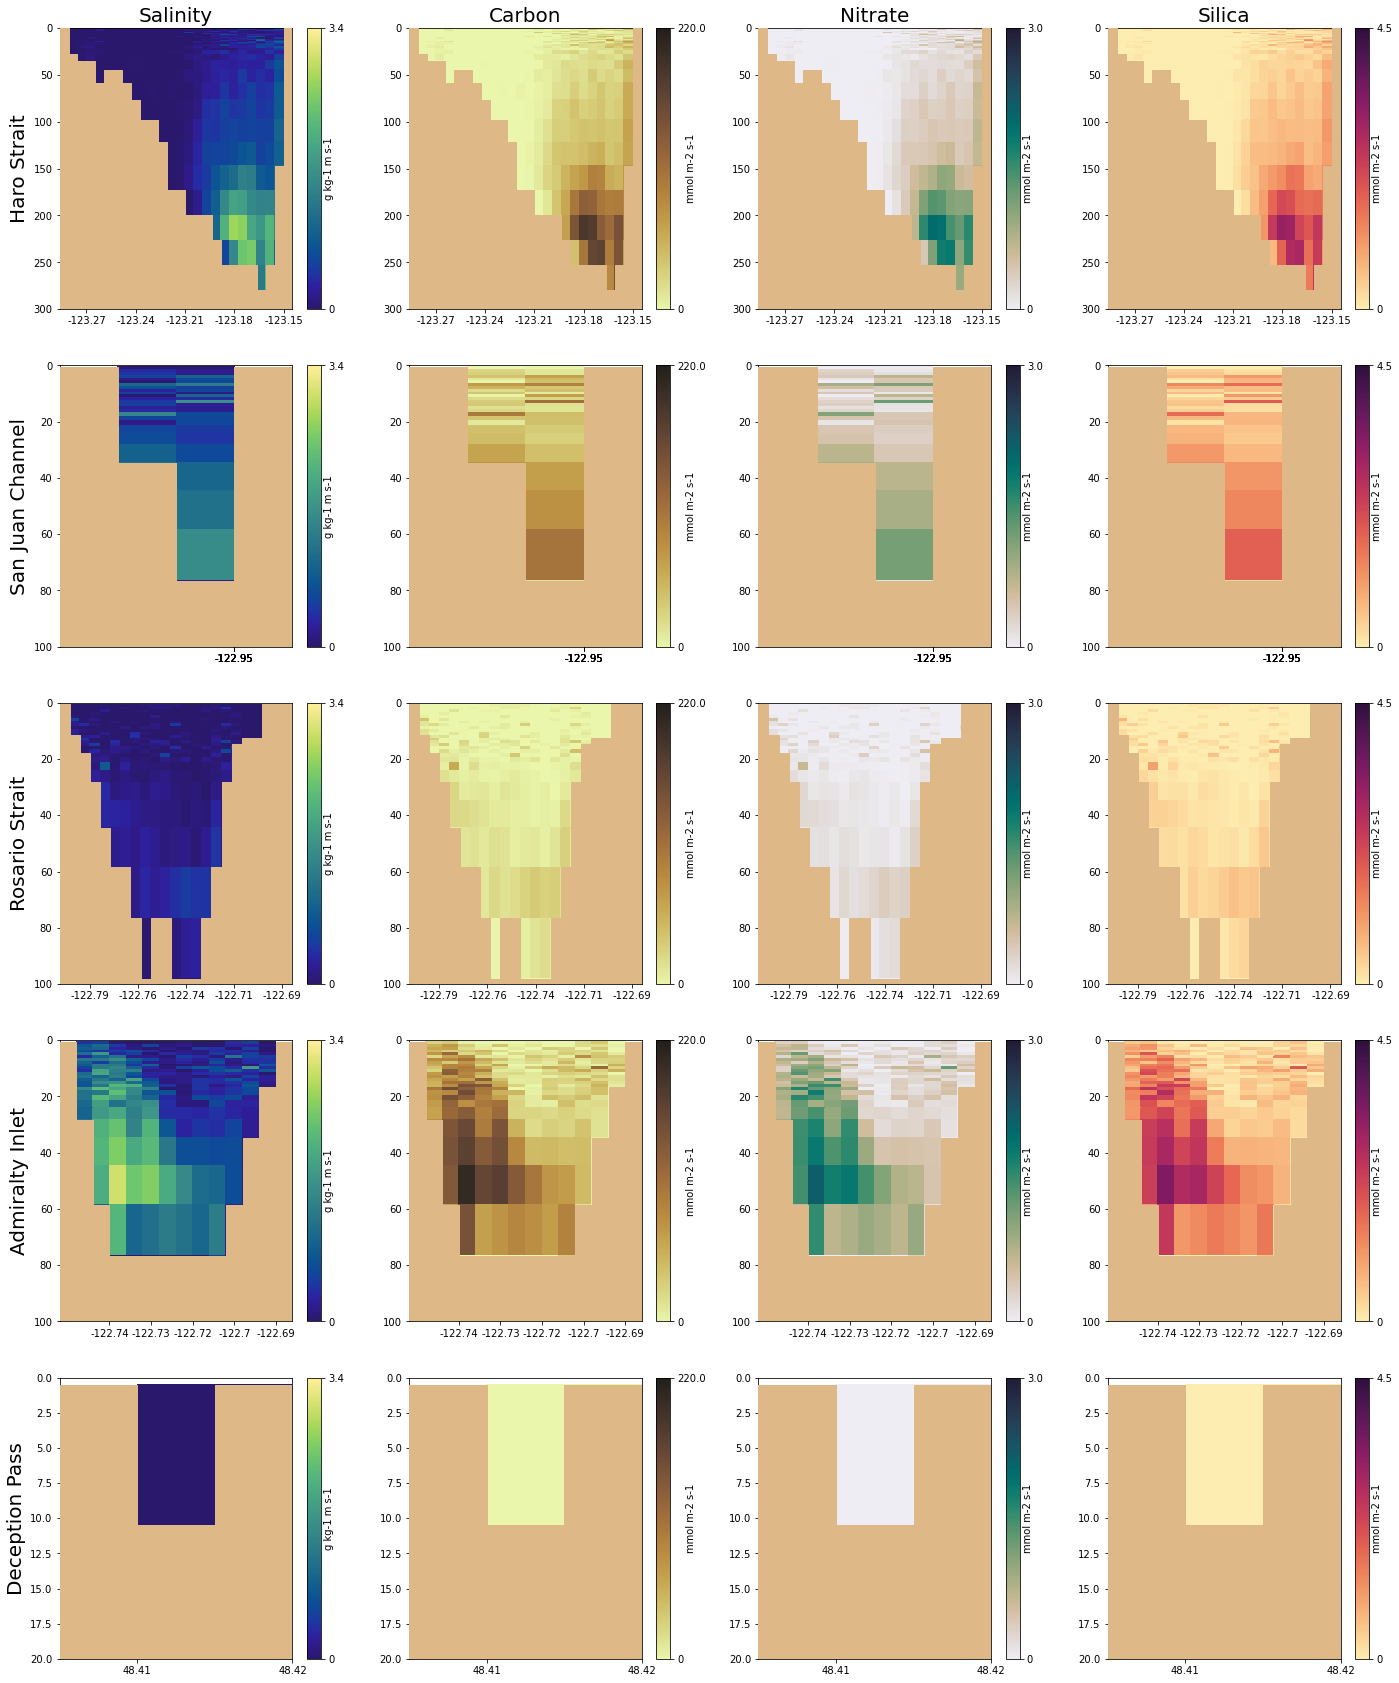

In [22]:
fig, axs = plt.subplots(5, 4, figsize = (24, 30))
TracerFluxCS(mydata, 'salt', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,0], "Haro In, Salinity")
TracerFluxCS(mydata, 'carbon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,1], "Haro In, Carbon")
TracerFluxCS(mydata2, 'nitrate', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,2], "Haro In, Nitrate")
TracerFluxCS(mydata2, 'silicon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,3], "Haro In, Silicon")

TracerFluxCS(mydata, 'salt', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 0], "San Juan In, Salinity")
TracerFluxCS(mydata, 'carbon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 1], "San Juan In, Carbon")
TracerFluxCS(mydata2, 'nitrate', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 2], "San Juan In, Nitrate")
TracerFluxCS(mydata2, 'silicon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 3], "San Juan In, Silicon")

TracerFluxCS(mydata, 'salt', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 0], "Rosario In, Salinity")
TracerFluxCS(mydata, 'carbon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 1], "Rosario In, Carbon")
TracerFluxCS(mydata2, 'nitrate', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 2], "Rosario In, Nitrate")
TracerFluxCS(mydata2, 'silicon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 3], "Rosario In, Silicon")

TracerFluxCS(mydata, 'salt', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 0], "Admiralty In, Salinity")
TracerFluxCS(mydata, 'carbon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 1], "Admiralty In, Carbon")
TracerFluxCS(mydata2, 'nitrate', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 2], "Admiralty In, Nitrate")
TracerFluxCS(mydata2, 'silicon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 3], "Admiralty In, Silicon")

DtracerFluxCS(mydata, 'salt', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,0], "Deception In, Salinity")
DtracerFluxCS(mydata, 'carbon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,1], "Deception In, Carbon")
DtracerFluxCS(mydata2, 'nitrate', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,2], "Deception In, Nitrate")
DtracerFluxCS(mydata2, 'silicon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,3], "Deception In, Silicon")

axs[0,0].set_ylabel('Haro Strait', fontsize = 20)
axs[1,0].set_ylabel('San Juan Channel', fontsize = 20)
axs[2,0].set_ylabel('Rosario Strait', fontsize = 20)
axs[3,0].set_ylabel('Admiralty Inlet', fontsize = 20)
axs[4,0].set_ylabel('Deception Pass', fontsize = 20)
axs[0,0].set_title('Salinity', fontsize = 20)
axs[0,1].set_title('Carbon', fontsize = 20)
axs[0,2].set_title('Nitrate', fontsize = 20)
axs[0,3].set_title('Silica', fontsize = 20)

# lets just do JR for 2018

In [6]:
def JRTracerFluxCS(tracername, lonW, lonE, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = 720
    
    lons = mydata.init_lon[(mydata.final_section != 0)]
    lats = mydata.init_lat[(mydata.final_section != 0)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    depths = depthf(mydata.init_z[(mydata.final_section != 0)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section != 0)]/time
    
    if tracername == 'salt' or tracername == 'silicon':
        tracer = mydata.init_salt[(mydata.final_section != 0)]
        if tracername == 'salt':
            t_max = round(34 * 0.1,1)
            cmap = cm.haline
        else:
            t_max = round(45 * 0.1,1)
            cmap = cm.matter
    elif tracername == 'temp' or tracername == 'nitrate' or tracername == 'carbon':
        tracer = mydata.init_temp[(mydata.final_section != 0)]
        if tracername == 'nitrate':
            t_max = round(30 * 0.1,1)
            cmap = cm.rain
        else:
            t_max = round(2200 * 0.1,1)
            cmap = cm.turbid
    else:
        print('incorrect tracer name, options are salt, temp, silicon, carbon, nitrate')

               
    H1, xedges1, yedges1 = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transports, density= True)# vmax=vmax)

    H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[lonW-1:lonE]), t_depths])
    _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[lonW-1:lonE]), t_depths])
       
    H_final = H1.T * H.statistic.T * float(sum(transports))
    np.nan_to_num(H_final, nan=0, copy=False)
    

    X, Y = np.meshgrid(xedges, yedges)
#     cmap.set_bad('grey', None)
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, vmin = 0, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, t_max]) 
    cb1.set_label('g kg-1 m s-1', labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[lonW+1], t_dist[lonE-1], 5))
    ax.set_xticklabels(np.round(np.linspace(t_lons[lonW+1], t_lons[lonE-1], 5),2))
    ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title))
    mydata.close()

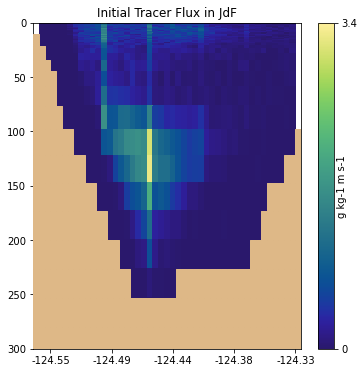

In [7]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01jan18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
#in the format [tracer, jgridW, jgridE, figrid, maxdepth, ax, title]
JRTracerFluxCS('salt', 18, 63, 377, 300, ax, "Initial Tracer Flux in JdF")

### hmmmmm this wasn't the point of this exercise but I REALLY dont like that the diagonal-ness of this CS artificially leads to those "high flux" vertical lines
i've alredy done a results comparison between the "straight" and "diagonal" segrid line and they are pretty close <br>
unsurprisingly the diagonal like consistently results in higher fluxes, likely due to the doubling up of the cross section 10 times (although only 5 of them are visible to me here?) <br>
I think for now this is FINE because it doesnt cause funky results BUT if you decide that you want some initial JR CS in your thesis then you should rerun to get rid of the lines

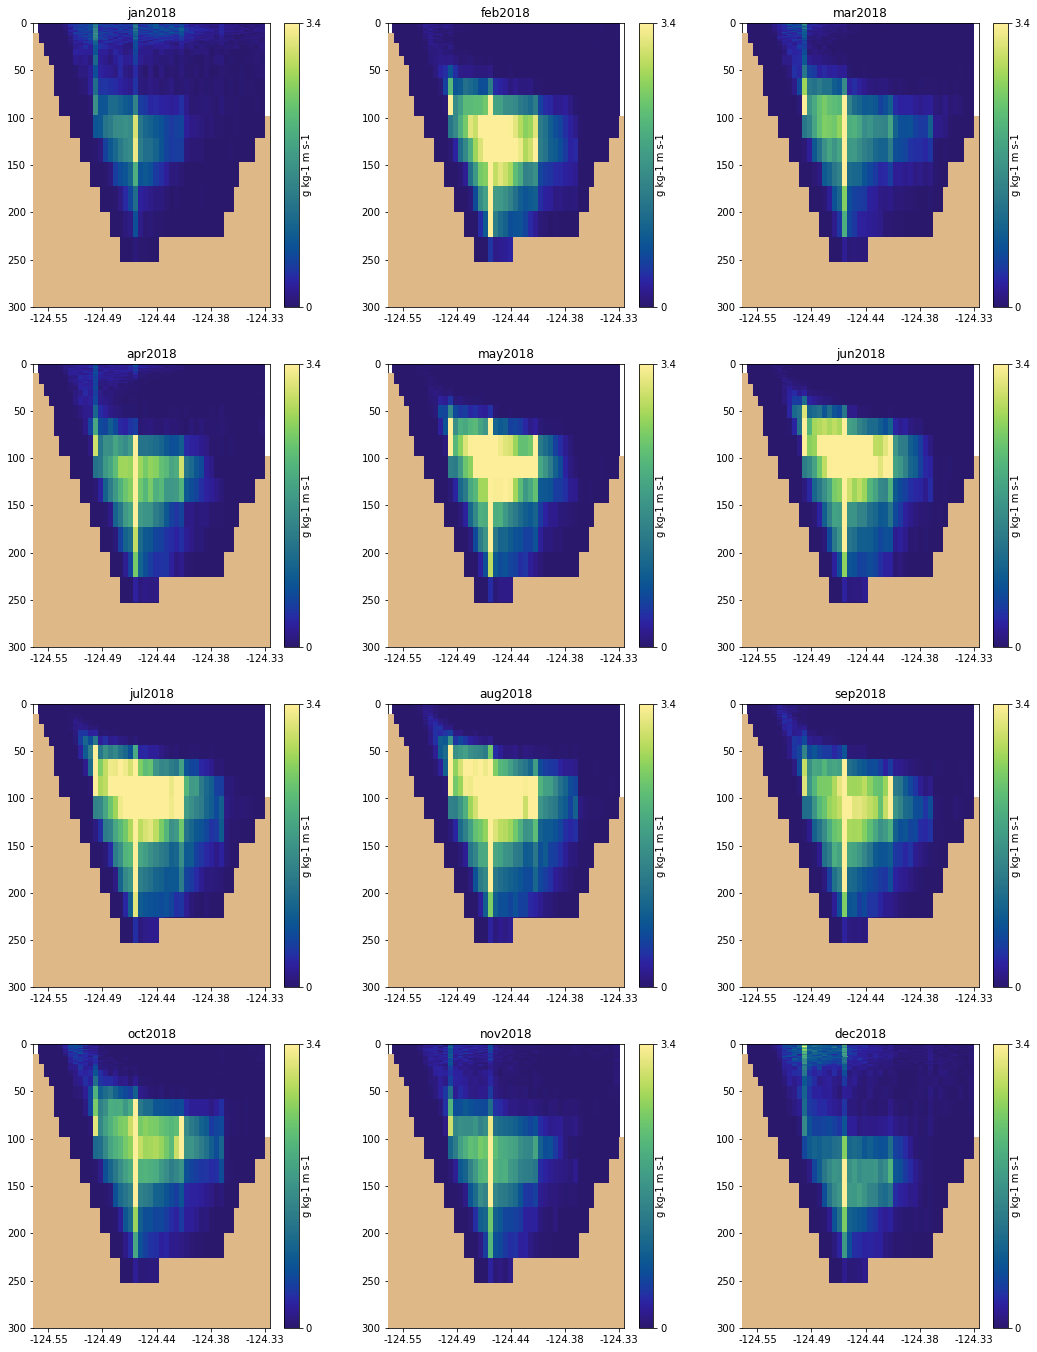

In [8]:
# for loop to get all 12 months at JR in 2018 - forward for now
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
fig, ax = plt.subplots(4, 3, figsize = (18, 24))

k=0
for i in range(len(str_mo)):
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01'+str_mo[i]+'18/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    
    #in the format [tracer, jgridW, jgridE, figrid, maxdepth, ax, title]
    JRTracerFluxCS('salt', 18, 63, 377, 300, ax[i//3,k], str_mo[i]+"2018")
    
    if k == 2:
        k=0
    else:
        k +=1

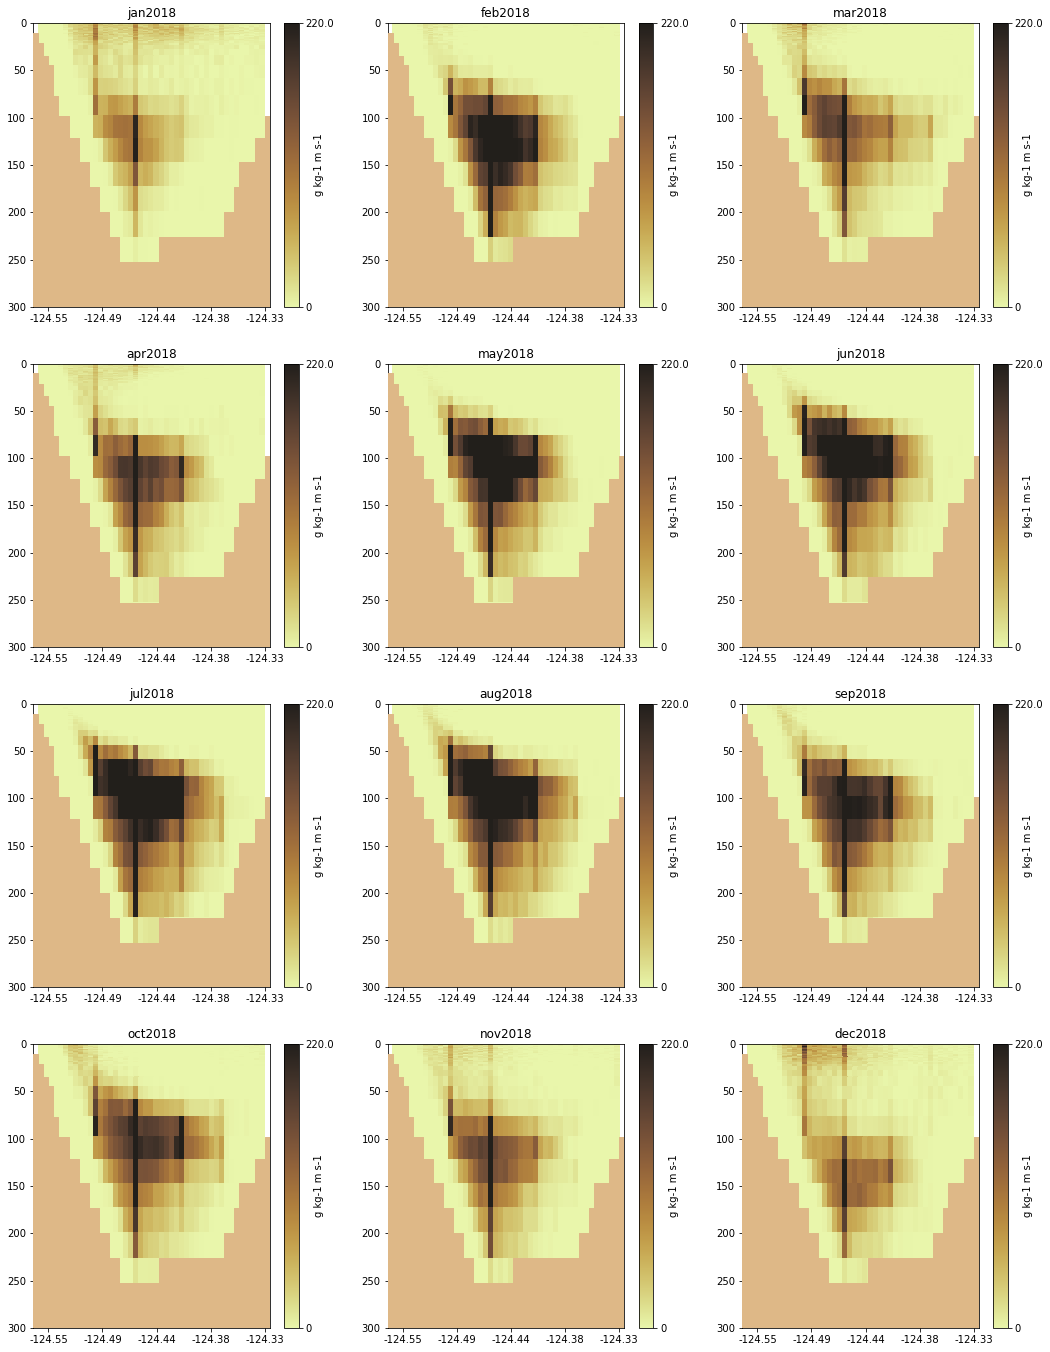

In [9]:
# for loop to get all 12 months at JR in 2018 - forward for now
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
fig, ax = plt.subplots(4, 3, figsize = (18, 24))

k=0
for i in range(len(str_mo)):
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01'+str_mo[i]+'18/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    
    JRTracerFluxCS('carbon', 18, 63, 377, 300, ax[i//3,k], str_mo[i]+"2018")
    
    if k == 2:
        k=0
    else:
        k +=1

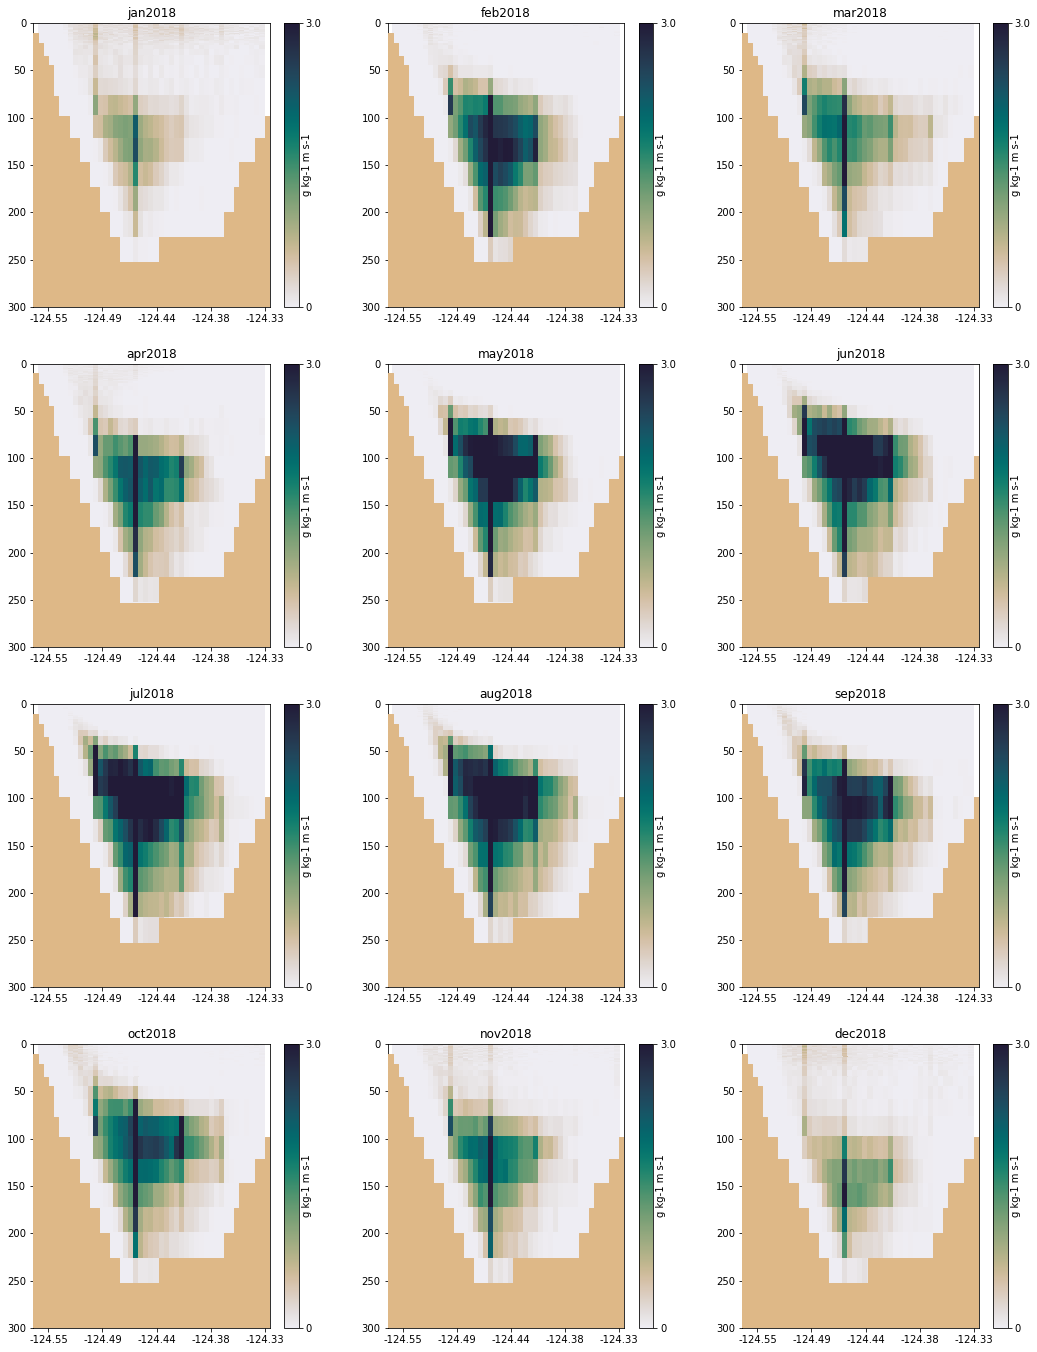

In [10]:
# for loop to get all 12 months at JR in 2018 - forward for now
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
fig, ax = plt.subplots(4, 3, figsize = (18, 24))

k=0
for i in range(len(str_mo)):
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01'+str_mo[i]+'18/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    
    JRTracerFluxCS('nitrate', 18, 63, 377, 300, ax[i//3,k], str_mo[i]+"2018")
    
    if k == 2:
        k=0
    else:
        k +=1

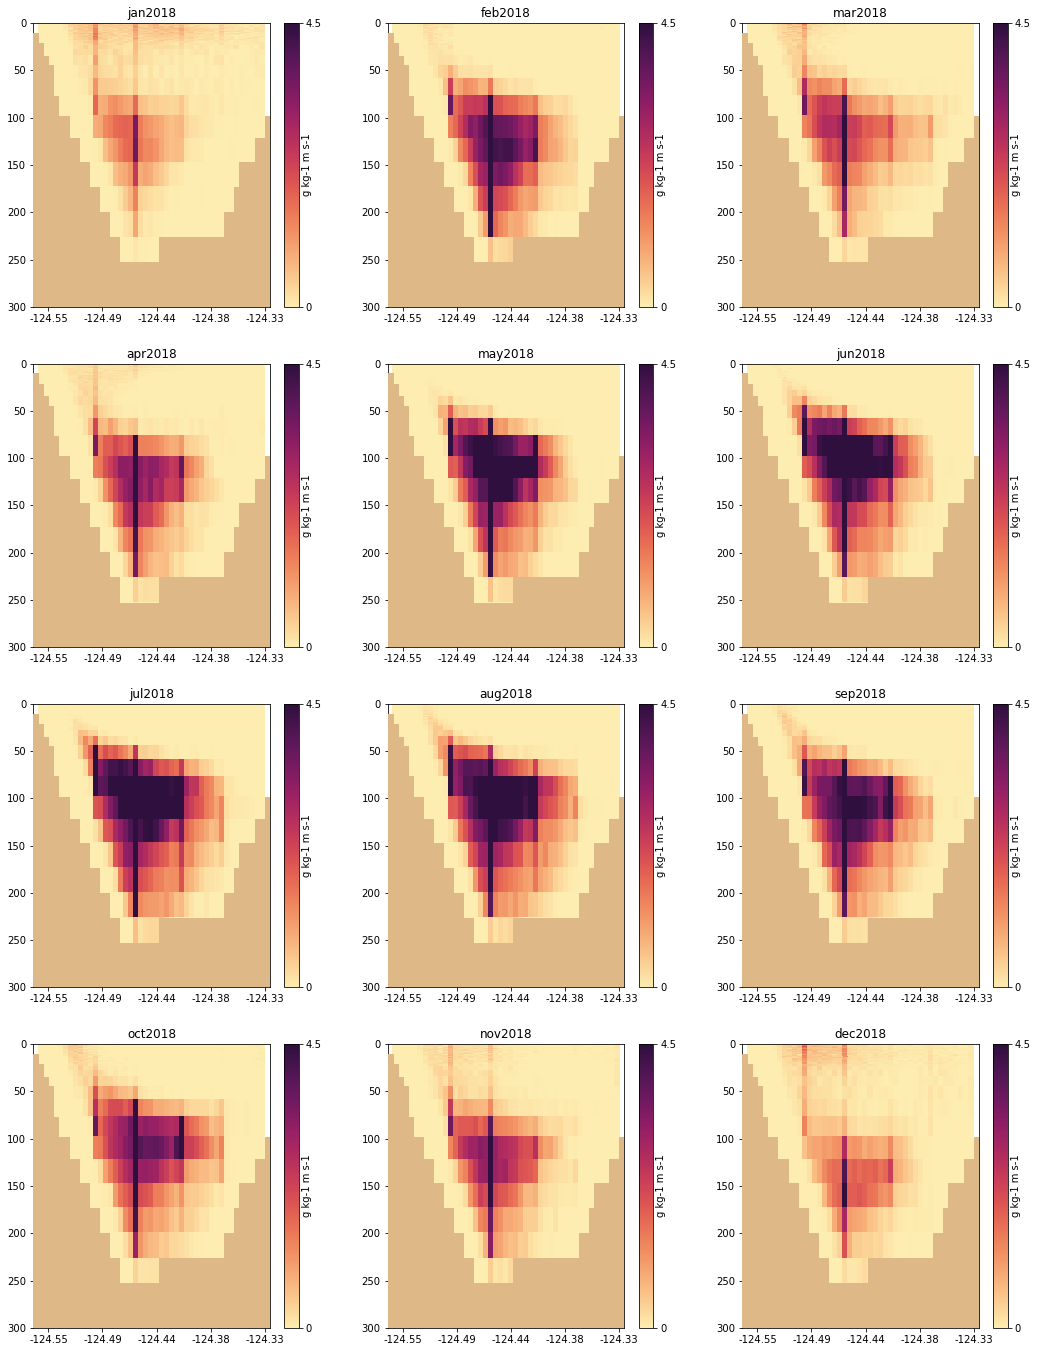

In [11]:
# for loop to get all 12 months at JR in 2018 - forward for now
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
fig, ax = plt.subplots(4, 3, figsize = (18, 24))

k=0
for i in range(len(str_mo)):
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01'+str_mo[i]+'18/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    
    JRTracerFluxCS('silicon', 18, 63, 377, 300, ax[i//3,k], str_mo[i]+"2018")
    
    if k == 2:
        k=0
    else:
        k +=1

## for 1 summer and 1 winter month plot JR CS flux seperately for each channel the water parcels end up in
i think January looks good as a winter "transient" flow and May looks good as an almost entirely "estuarine"

In [12]:
lonW, lonE, figrid, maxdepth = 18, 63, 377, 300
sections = [2,3,4,5,6] # admiralty, deception, rosario, san juan, haro
section_name = ['admiralty', 'deception', 'rosario', 'san juan', 'haro']

def JR_to_channels(tracername, section, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = 720
    
    lons = mydata.init_lon[(mydata.final_section == section)]
    lats = mydata.init_lat[(mydata.final_section == section)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    depths = depthf(mydata.init_z[(mydata.final_section == section)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section == section)]/time
    
    if tracername == 'salt' or tracername == 'silicon':
        tracer = mydata.init_salt[(mydata.final_section == section)]
        if tracername == 'salt':
            t_max = round(25 * 0.1,1)
            cmap = cm.haline
            units = 'g kg-1 m s-1'
        else:
            t_max = round(25 * 0.1,1)
            cmap = cm.matter
            units = 'mmol m-2 s-1'
    elif tracername == 'temp' or tracername == 'nitrate' or tracername == 'carbon':
        tracer = mydata.init_temp[(mydata.final_section == section)]
        if tracername == 'nitrate':
            t_max = round(15 * 0.1,1)
            cmap = cm.rain
            units = 'mmol m-2 s-1'
        else:
            t_max = round(1200 * 0.1,1)
            cmap = cm.turbid
            units = 'mmol m-2 s-1'
    else:
        print('incorrect tracer name, options are salt, temp, silicon, carbon, nitrate')

               
    H1, xedges1, yedges1 = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transports, density= True)# vmax=vmax)

    H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[lonW-1:lonE]), t_depths])
    _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[lonW-1:lonE]), t_depths])
       
    H_final = H1.T * H.statistic.T * float(sum(transports))
    np.nan_to_num(H_final, nan=0, copy=False)
    

    X, Y = np.meshgrid(xedges, yedges)
#     cmap.set_bad('grey', None)
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, vmin = 0, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, t_max]) 
    cb1.set_label(units, labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[lonW+1], t_dist[lonE-1], 5))
    ax.set_xticklabels(np.round(np.linspace(t_lons[lonW+1], t_lons[lonE-1], 5),2))
    ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title))
    mydata.close()

#### January

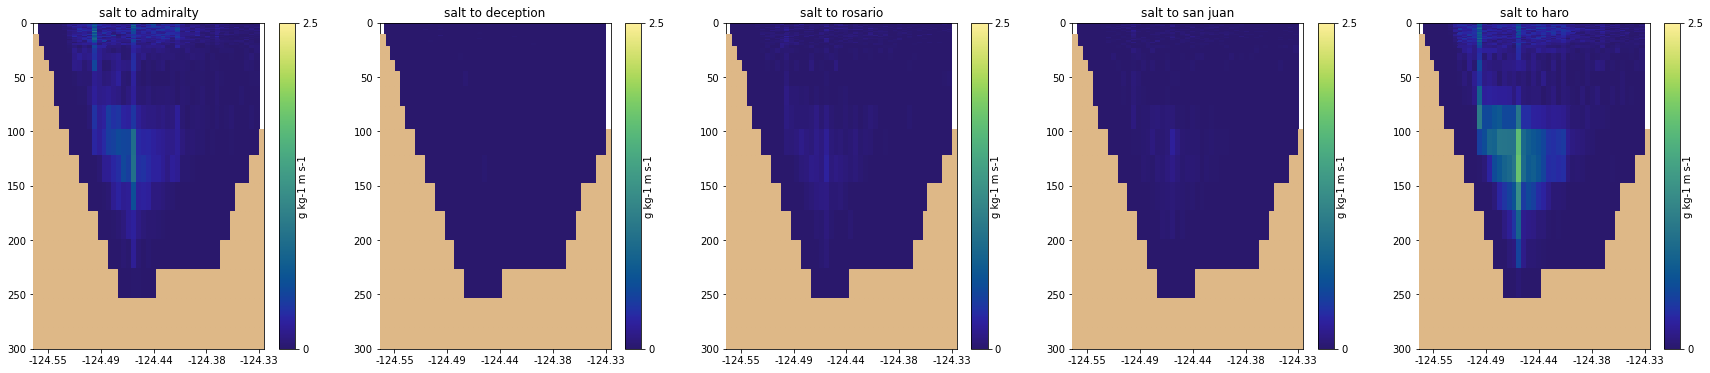

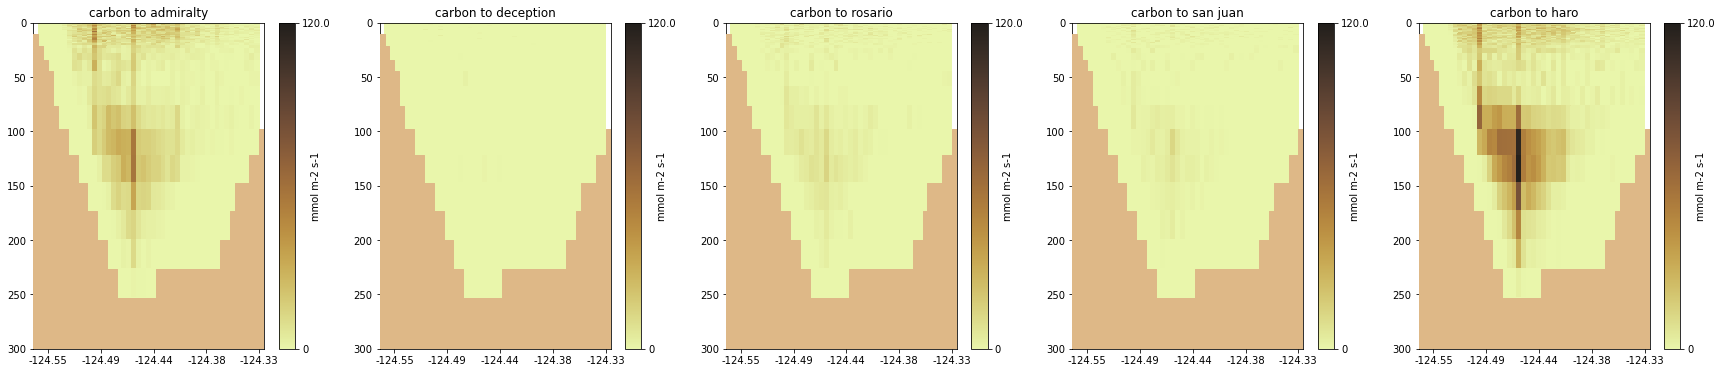

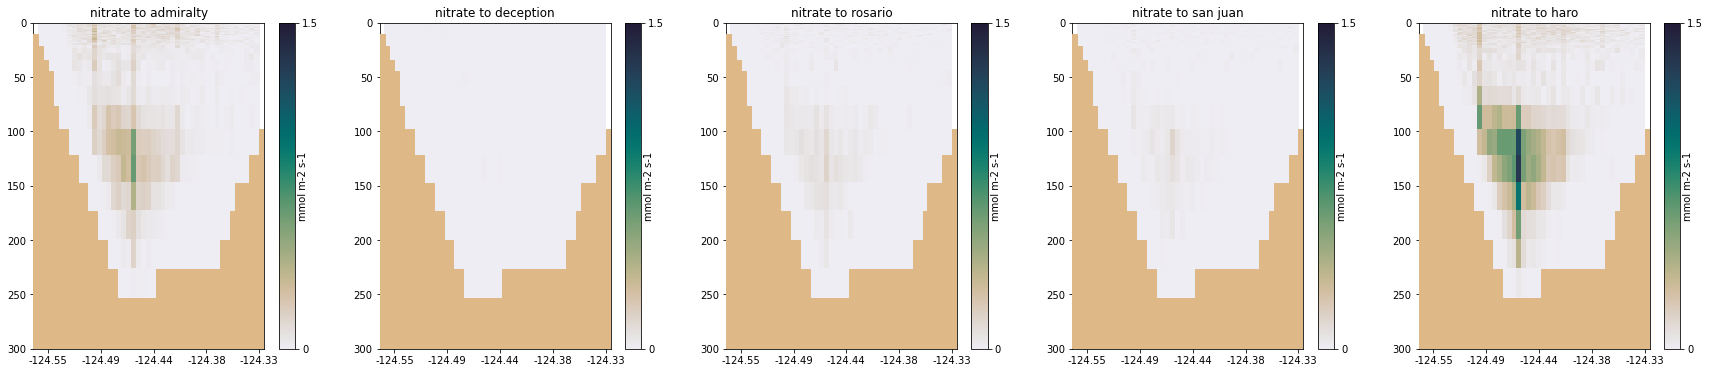

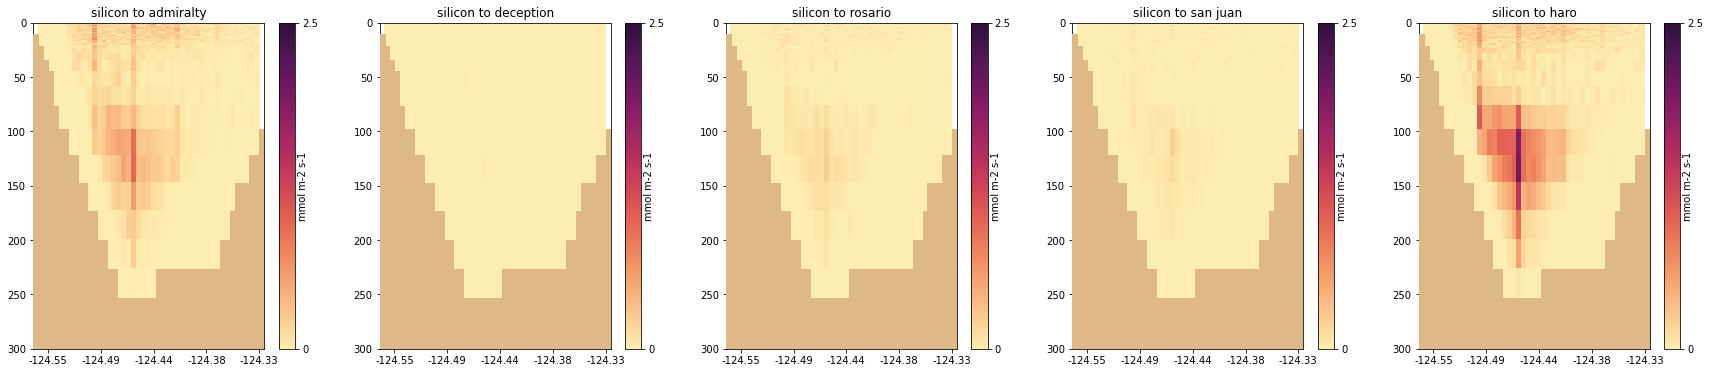

In [13]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01jan18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

fig, ax = plt.subplots(1, 5, figsize = (30, 6))
tracername = 'salt'
for i in range(len(sections)):
    JR_to_channels(tracername, sections[i], ax[i], tracername+" to "+section_name[i])
    
    
fig, ax = plt.subplots(1, 5, figsize = (30, 6))
tracername = 'carbon'
for i in range(len(sections)):
    JR_to_channels(tracername, sections[i], ax[i], tracername+" to "+section_name[i])
    
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01jan18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

fig, ax = plt.subplots(1, 5, figsize = (30, 6))
tracername = 'nitrate'
for i in range(len(sections)):
    JR_to_channels(tracername, sections[i], ax[i], tracername+" to "+section_name[i])
    
fig, ax = plt.subplots(1, 5, figsize = (30, 6))
tracername = 'silicon'
for i in range(len(sections)):
    JR_to_channels(tracername, sections[i], ax[i], tracername+" to "+section_name[i])

### May

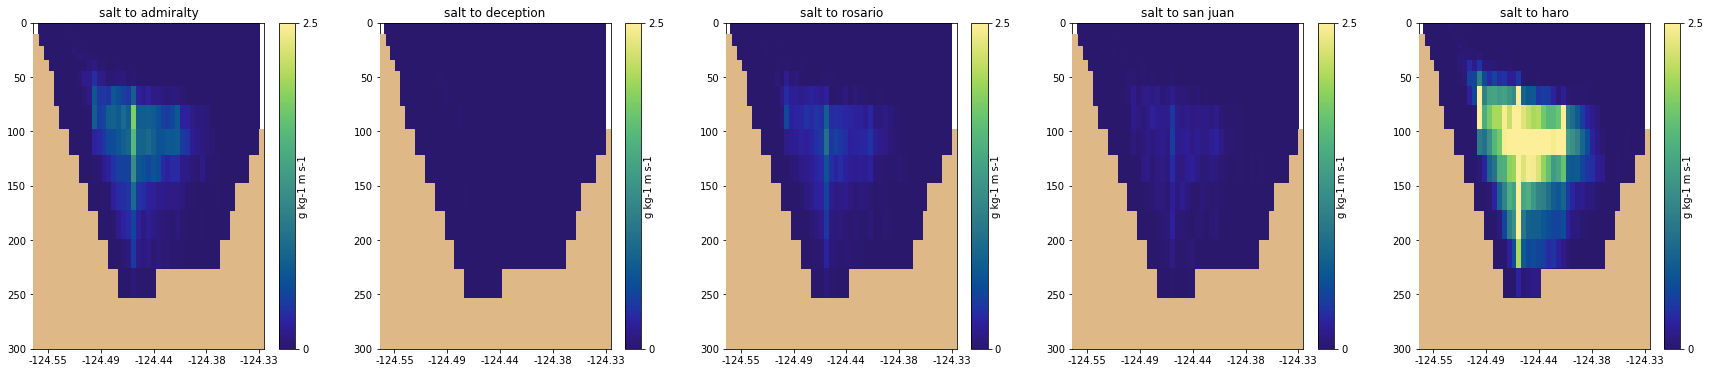

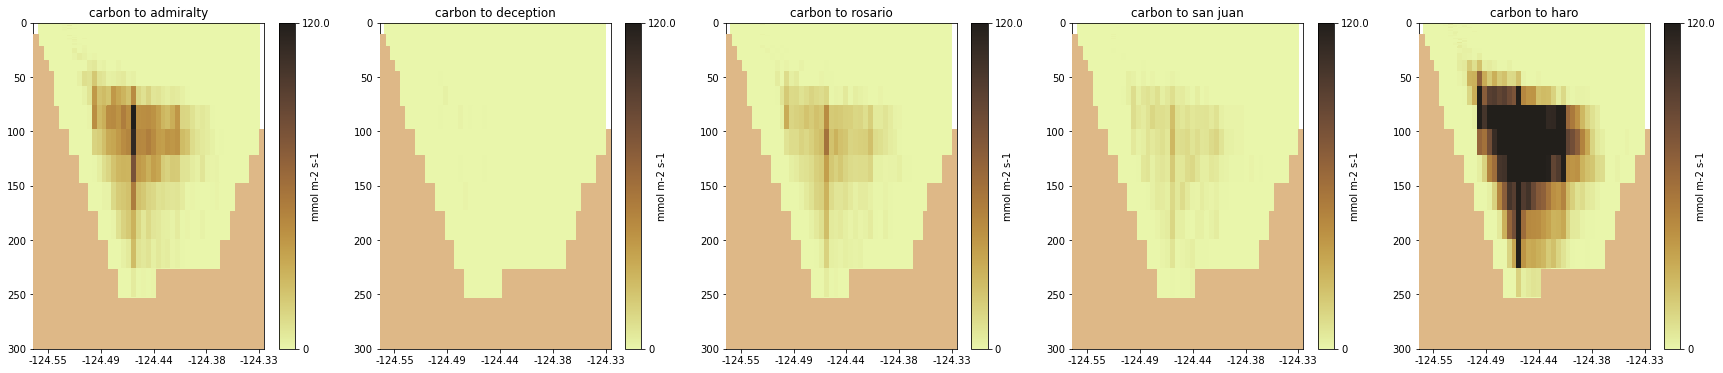

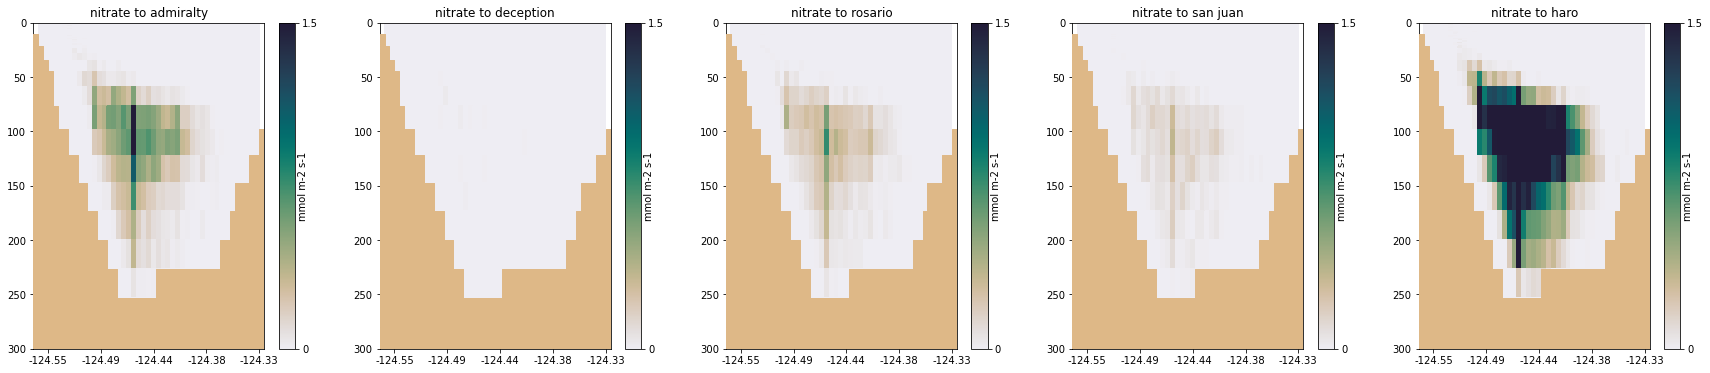

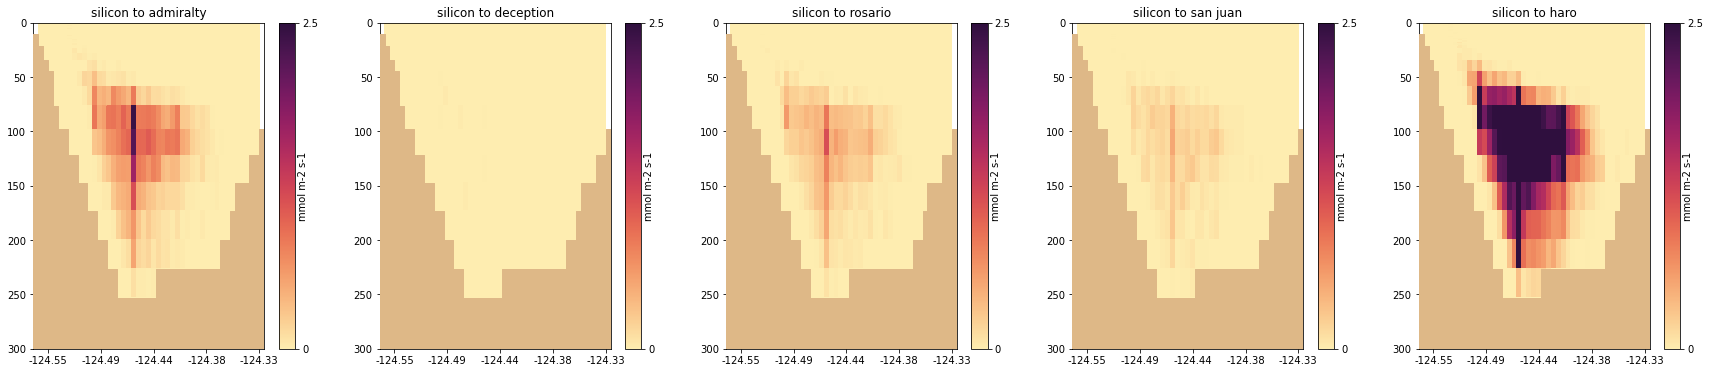

In [14]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01may18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

fig, ax = plt.subplots(1, 5, figsize = (30, 6))
tracername = 'salt'
for i in range(len(sections)):
    JR_to_channels(tracername, sections[i], ax[i], tracername+" to "+section_name[i])
    
    
fig, ax = plt.subplots(1, 5, figsize = (30, 6))
tracername = 'carbon'
for i in range(len(sections)):
    JR_to_channels(tracername, sections[i], ax[i], tracername+" to "+section_name[i])
    
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01may18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)

fig, ax = plt.subplots(1, 5, figsize = (30, 6))
tracername = 'nitrate'
for i in range(len(sections)):
    JR_to_channels(tracername, sections[i], ax[i], tracername+" to "+section_name[i])
    
fig, ax = plt.subplots(1, 5, figsize = (30, 6))
tracername = 'silicon'
for i in range(len(sections)):
    JR_to_channels(tracername, sections[i], ax[i], tracername+" to "+section_name[i])

### Now lets make a nice lil histogram to look at the composition of the water and how it changes

##### we want to do this for allllll the years though - still Jan and May makes sense

In [15]:
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
jan_start = 1
jan_end = 720
may_start = 1+(4*720+(sum(yearjumps[:5]*24)))
may_end = 720+(4*720+(sum(yearjumps[:5]*24)))

In [16]:
c = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
labels = ['2016','2017','2018','2019','2020']

In [17]:
# time=720

# #2016
# fig, ax = plt.subplots(1, 2, figsize = (15, 6))

# file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan16/ariane_positions_quantitative.nc'
# mydata = xr.open_dataset(file)
# tracer = mydata.init_salt[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= jan_end)]
# transport = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= jan_end)]/time
# ax[0].hist(tracer, bins=np.arange(29,35,0.5), weights= transport)
# ax[0].set_title('Salinity from the JdF, January 2016')
# ax[0].set_xlabel('Salinity [g/kg]')
# ax[0].set_ylim([0,56000])

# tracer = mydata.init_salt[(mydata.final_section != 0) & (mydata.init_t >= may_start) & (mydata.init_t <= may_end)]
# transport = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= may_start) & (mydata.init_t <= may_end)]/time
# ax[1].hist(tracer, bins=np.arange(29,35,0.5), weights= transport)
# ax[1].set_title('Salinity from the JdF, May 2016')
# ax[1].set_xlabel('Salinity [g/kg]')
# ax[1].set_ylim([0,56000])

# #2017
# fig, ax = plt.subplots(1, 2, figsize = (15, 6))

# file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan17/ariane_positions_quantitative.nc'
# mydata = xr.open_dataset(file)
# tracer = mydata.init_salt[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= jan_end)]
# transport = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= jan_end)]/time
# ax[0].hist(tracer, bins=np.arange(29,35,0.5), weights= transport)
# ax[0].set_title('Salinity from the JdF, January 2017')
# ax[0].set_xlabel('Salinity [g/kg]')
# ax[0].set_ylim([0,56000])

# tracer = mydata.init_salt[(mydata.final_section != 0) & (mydata.init_t >= may_start) & (mydata.init_t <= may_end)]
# transport = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= may_start) & (mydata.init_t <= may_end)]/time
# ax[1].hist(tracer, bins=np.arange(29,35,0.5), weights= transport)
# ax[1].set_title('Salinity from the JdF, May 2017')
# ax[1].set_xlabel('Salinity [g/kg]')
# ax[1].set_ylim([0,56000])


# #2018
# fig, ax = plt.subplots(1, 2, figsize = (15, 6))

# file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01jan18/ariane_positions_quantitative.nc'
# mydata = xr.open_dataset(file)
# tracer = mydata.init_salt[(mydata.final_section != 0)]
# transport = mydata.init_transp[(mydata.final_section != 0)]/time
# ax[0].hist(tracer, bins=np.arange(29,35,0.5), weights= transport)
# ax[0].set_title('Salinity from the JdF, January 2018')
# ax[0].set_xlabel('Salinity [g/kg]')
# ax[0].set_ylim([0,56000])

# file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01may18/ariane_positions_quantitative.nc'
# mydata = xr.open_dataset(file)
# tracer = mydata.init_salt[(mydata.final_section != 0)]
# transport = mydata.init_transp[(mydata.final_section != 0)]/time
# ax[1].hist(tracer, bins=np.arange(29,35,0.5), weights= transport)
# ax[1].set_title('Salinity from the JdF, May 2018')
# ax[1].set_xlabel('Salinity [g/kg]')
# ax[1].set_ylim([0,56000])

# #2019
# fig, ax = plt.subplots(1, 2, figsize = (15, 6))

# file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01jan19/ariane_positions_quantitative.nc'
# mydata = xr.open_dataset(file)
# tracer = mydata.init_salt[(mydata.final_section != 0)]
# transport = mydata.init_transp[(mydata.final_section != 0)]/time
# ax[0].hist(tracer, bins=np.arange(29,35,0.5), weights= transport)
# ax[0].set_title('Salinity from the JdF, January 2019')
# ax[0].set_xlabel('Salinity [g/kg]')
# ax[0].set_ylim([0,56000])

# file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01may19/ariane_positions_quantitative.nc'
# mydata = xr.open_dataset(file)
# tracer = mydata.init_salt[(mydata.final_section != 0)]
# transport = mydata.init_transp[(mydata.final_section != 0)]/time
# ax[1].hist(tracer, bins=np.arange(29,35,0.5), weights= transport)
# ax[1].set_title('Salinity from the JdF, May 2019')
# ax[1].set_xlabel('Salinity [g/kg]')
# ax[1].set_ylim([0,56000])

# #2020
# fig, ax = plt.subplots(1, 2, figsize = (15, 6))

# file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan20/ariane_positions_quantitative.nc'
# mydata = xr.open_dataset(file)
# tracer = mydata.init_salt[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= jan_end)]
# transport = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= jan_end)]/time
# ax[0].hist(tracer, bins=np.arange(29,35,0.5), weights= transport)
# ax[0].set_title('Salinity from the JdF, January 2020')
# ax[0].set_xlabel('Salinity [g/kg]')
# ax[0].set_ylim([0,56000])

# tracer = mydata.init_salt[(mydata.final_section != 0) & (mydata.init_t >= may_start) & (mydata.init_t <= may_end)]
# transport = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= may_start) & (mydata.init_t <= may_end)]/time
# ax[1].hist(tracer, bins=np.arange(29,35,0.5), weights= transport)
# ax[1].set_title('Salinity from the JdF, May 2020')
# ax[1].set_xlabel('Salinity [g/kg]')
# ax[1].set_ylim([0,56000])

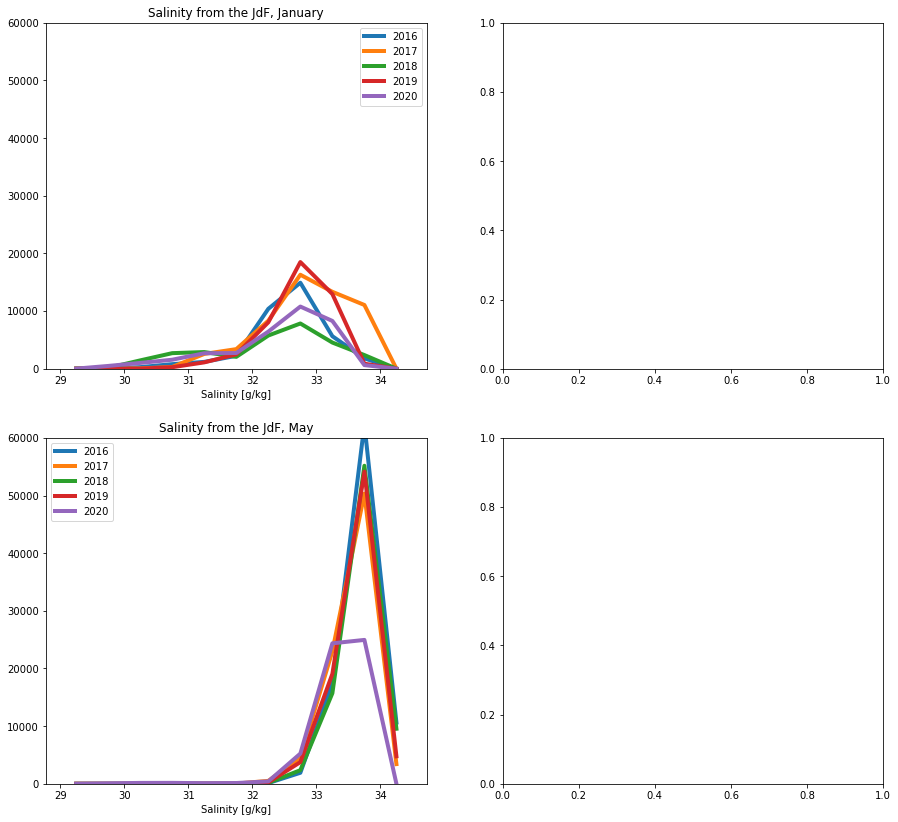

In [18]:
time=720
fig, ax = plt.subplots(2, 2, figsize = (15, 14))

#get all the data
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerJ16 = mydata.init_salt[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= jan_end)]
transportJ16 = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= jan_end)]/time
tracerM16 = mydata.init_salt[(mydata.final_section != 0) & (mydata.init_t >= may_start) & (mydata.init_t <= may_end)]
transportM16 = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= may_start) & (mydata.init_t <= may_end)]/time

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerJ17 = mydata.init_salt[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= jan_end)]
transportJ17 = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= jan_end)]/time
tracerM17 = mydata.init_salt[(mydata.final_section != 0) & (mydata.init_t >= may_start) & (mydata.init_t <= may_end)]
transportM17 = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= may_start) & (mydata.init_t <= may_end)]/time

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01jan18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerJ18 = mydata.init_salt[(mydata.final_section != 0)]
transportJ18 = mydata.init_transp[(mydata.final_section != 0)]/time

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01may18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerM18 = mydata.init_salt[(mydata.final_section != 0)]
transportM18 = mydata.init_transp[(mydata.final_section != 0)]/time

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01jan19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerJ19 = mydata.init_salt[(mydata.final_section != 0)]
transportJ19 = mydata.init_transp[(mydata.final_section != 0)]/time

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01may19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerM19 = mydata.init_salt[(mydata.final_section != 0)]
transportM19 = mydata.init_transp[(mydata.final_section != 0)]/time

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerJ20 = mydata.init_salt[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= jan_end)]
transportJ20 = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= jan_end)]/time
tracerM20 = mydata.init_salt[(mydata.final_section != 0) & (mydata.init_t >= may_start) & (mydata.init_t <= may_end)]
transportM20 = mydata.init_transp[(mydata.final_section != 0) & (mydata.init_t >= may_start) & (mydata.init_t <= may_end)]/time

#plt jan
jan_sal,x,_ = ax[0,0].hist([tracerJ16,tracerJ17,tracerJ18,tracerJ19,tracerJ20], bins=np.arange(29,35,0.5), weights= [transportJ16,transportJ17,transportJ18,transportJ19,transportJ20], color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])
for i in range(np.shape(jan_sal)[0]):
    ax[0,0].plot(bin_centers,jan_sal[i], linewidth = 4, label=labels[i])
ax[0,0].set_title('Salinity from the JdF, January')
ax[0,0].set_xlabel('Salinity [g/kg]')
ax[0,0].set_ylim([0,60000])
ax[0,0].legend()

#plt may
may_sal,x,_ = ax[1,0].hist([tracerM16,tracerM17,tracerM18,tracerM19,tracerM20], bins=np.arange(29,35,0.5), weights= [transportM16,transportM17,transportM18,transportM19,transportM20],  color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])
for i in range(np.shape(may_sal)[0]):
    ax[1,0].plot(bin_centers,may_sal[i], linewidth = 4, label=labels[i])
ax[1,0].set_title('Salinity from the JdF, May')
ax[1,0].set_xlabel('Salinity [g/kg]')
ax[1,0].set_ylim([0,60000])
ax[1,0].legend()

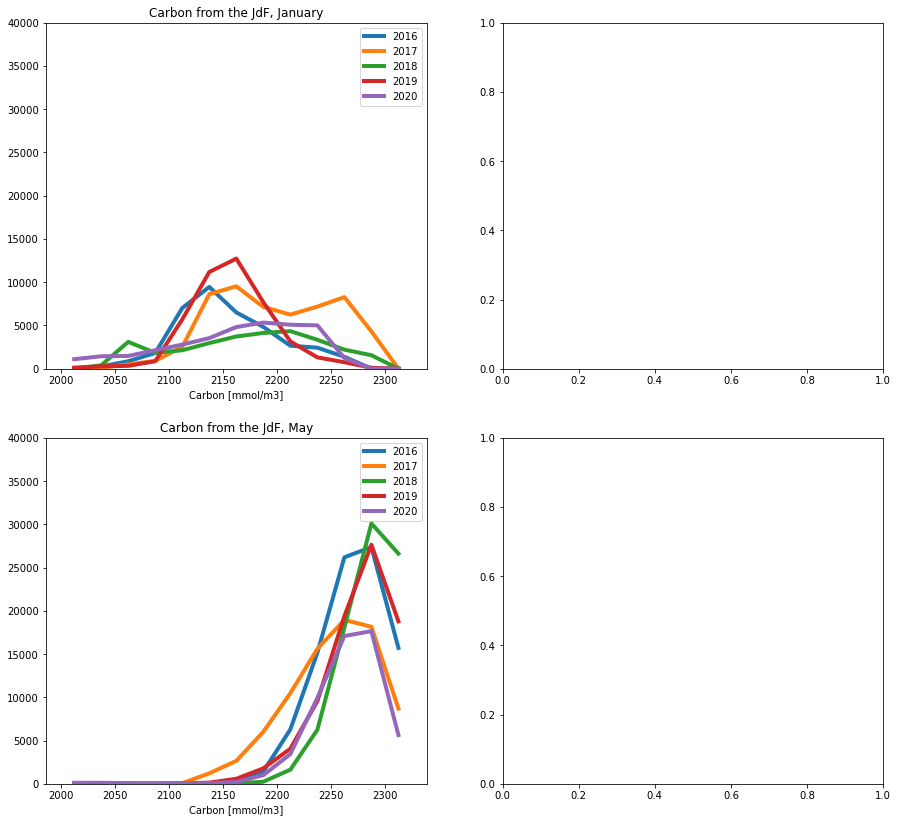

In [19]:
#CARBON
bins = np.arange(2000,2350,25)
time=720
fig, ax = plt.subplots(2, 2, figsize = (15, 14))

#get all the data
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerJ16 = mydata.init_temp[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= jan_end)]
tracerM16 = mydata.init_temp[(mydata.final_section != 0) & (mydata.init_t >= may_start) & (mydata.init_t <= may_end)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerJ17 = mydata.init_temp[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= jan_end)]
tracerM17 = mydata.init_temp[(mydata.final_section != 0) & (mydata.init_t >= may_start) & (mydata.init_t <= may_end)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01jan18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerJ18 = mydata.init_temp[(mydata.final_section != 0)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01may18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerM18 = mydata.init_temp[(mydata.final_section != 0)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01jan19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerJ19 = mydata.init_temp[(mydata.final_section != 0)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01may19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerM19 = mydata.init_temp[(mydata.final_section != 0)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Car_Sal/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerJ20 = mydata.init_temp[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= jan_end)]
tracerM20 = mydata.init_temp[(mydata.final_section != 0) & (mydata.init_t >= may_start) & (mydata.init_t <= may_end)]

#plt jan
jan_car,x,_ = ax[0,0].hist([tracerJ16,tracerJ17,tracerJ18,tracerJ19,tracerJ20], bins=bins, weights= [transportJ16,transportJ17,transportJ18,transportJ19,transportJ20], color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])
for i in range(np.shape(jan_car)[0]):
    ax[0,0].plot(bin_centers,jan_car[i], linewidth = 4, label=labels[i])
ax[0,0].set_title('Carbon from the JdF, January')
ax[0,0].set_xlabel('Carbon [mmol/m3]')
ax[0,0].set_ylim([0,40000])
ax[0,0].legend()

#plt may
may_car,x,_ = ax[1,0].hist([tracerM16,tracerM17,tracerM18,tracerM19,tracerM20], bins=bins, weights= [transportM16,transportM17,transportM18,transportM19,transportM20], color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])
for i in range(np.shape(may_car)[0]):
    ax[1,0].plot(bin_centers,may_car[i], linewidth = 4, label=labels[i])
ax[1,0].set_title('Carbon from the JdF, May')
ax[1,0].set_xlabel('Carbon [mmol/m3]')
ax[1,0].set_ylim([0,40000])
ax[1,0].legend()

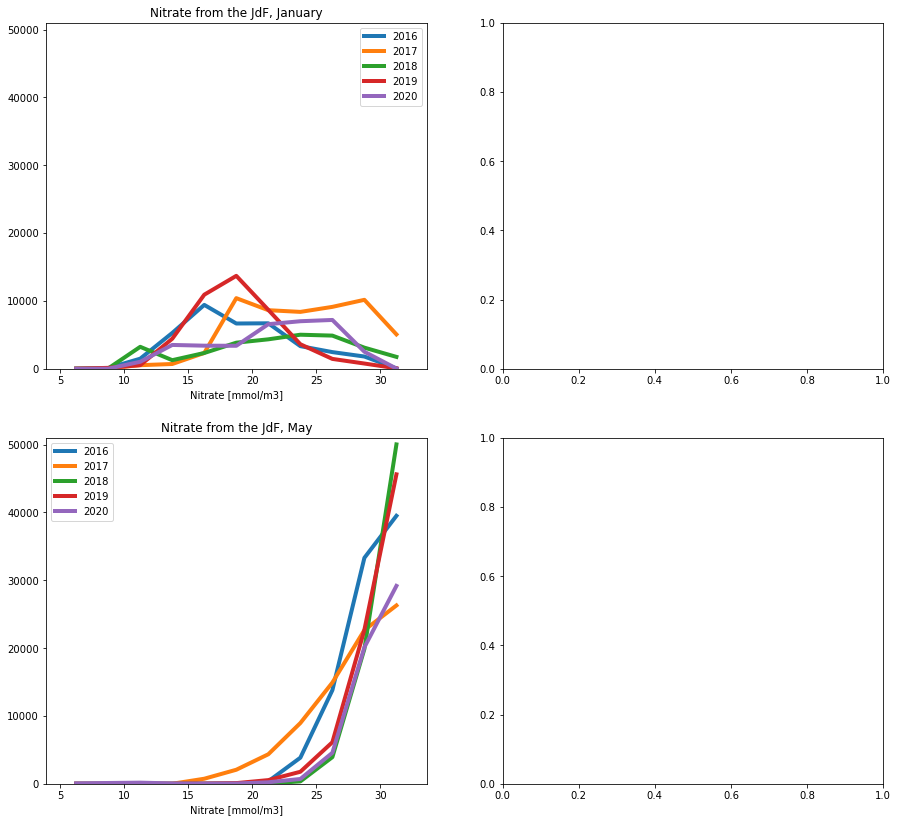

In [20]:
#NITRATE
bins = np.arange(5,35,2.5)
time=720
fig, ax = plt.subplots(2, 2, figsize = (15, 14))

#get all the data
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Nit_Sil/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerJ16 = mydata.init_temp[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= jan_end)]
tracerM16 = mydata.init_temp[(mydata.final_section != 0) & (mydata.init_t >= may_start) & (mydata.init_t <= may_end)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Nit_Sil/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerJ17 = mydata.init_temp[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= jan_end)]
tracerM17 = mydata.init_temp[(mydata.final_section != 0) & (mydata.init_t >= may_start) & (mydata.init_t <= may_end)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01jan18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerJ18 = mydata.init_temp[(mydata.final_section != 0)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01may18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerM18 = mydata.init_temp[(mydata.final_section != 0)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01jan19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerJ19 = mydata.init_temp[(mydata.final_section != 0)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01may19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerM19 = mydata.init_temp[(mydata.final_section != 0)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Nit_Sil/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerJ20 = mydata.init_temp[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= jan_end)]
tracerM20 = mydata.init_temp[(mydata.final_section != 0) & (mydata.init_t >= may_start) & (mydata.init_t <= may_end)]

#plt jan
jan_nit,x,_ = ax[0,0].hist([tracerJ16,tracerJ17,tracerJ18,tracerJ19,tracerJ20], bins=bins, weights= [transportJ16,transportJ17,transportJ18,transportJ19,transportJ20],  color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])
for i in range(np.shape(jan_nit)[0]):
    ax[0,0].plot(bin_centers,jan_nit[i], linewidth = 4, label=labels[i])
ax[0,0].set_title('Nitrate from the JdF, January')
ax[0,0].set_xlabel('Nitrate [mmol/m3]')
ax[0,0].set_ylim([0,51000])
ax[0,0].legend()

#plt may
may_nit,x,_ = ax[1,0].hist([tracerM16,tracerM17,tracerM18,tracerM19,tracerM20], bins=bins, weights= [transportM16,transportM17,transportM18,transportM19,transportM20],  color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])
for i in range(np.shape(may_nit)[0]):
    ax[1,0].plot(bin_centers,may_nit[i], linewidth = 4, label=labels[i])
ax[1,0].set_title('Nitrate from the JdF, May')
ax[1,0].set_xlabel('Nitrate [mmol/m3]')
ax[1,0].set_ylim([0,51000])
ax[1,0].legend()

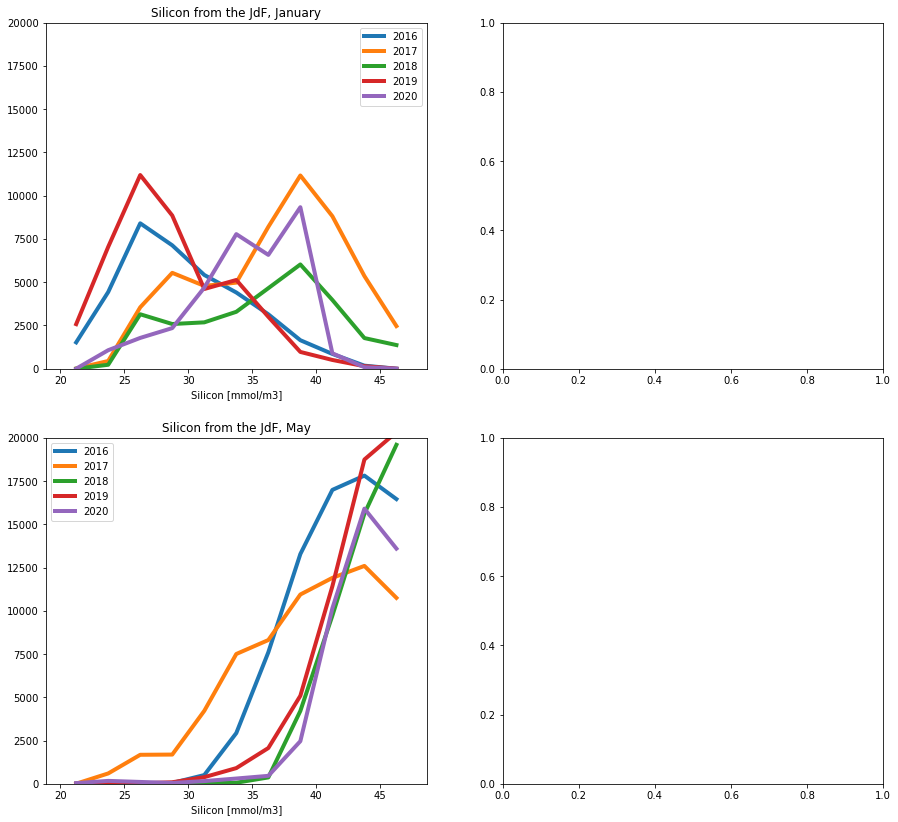

In [21]:
#SILICON
bins = np.arange(20,50,2.5)
time=720
fig, ax = plt.subplots(2, 2, figsize = (15, 14))

#get all the data
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Nit_Sil/forward_01jan16/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerJ16 = mydata.init_salt[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= jan_end)]
tracerM16 = mydata.init_salt[(mydata.final_section != 0) & (mydata.init_t >= may_start) & (mydata.init_t <= may_end)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Nit_Sil/forward_01jan17/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerJ17 = mydata.init_salt[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= jan_end)]
tracerM17 = mydata.init_salt[(mydata.final_section != 0) & (mydata.init_t >= may_start) & (mydata.init_t <= may_end)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01jan18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerJ18 = mydata.init_salt[(mydata.final_section != 0)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01may18/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerM18 = mydata.init_salt[(mydata.final_section != 0)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01jan19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerJ19 = mydata.init_salt[(mydata.final_section != 0)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01may19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerM19 = mydata.init_salt[(mydata.final_section != 0)]

file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_Nit_Sil/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
tracerJ20 = mydata.init_salt[(mydata.final_section != 0) & (mydata.init_t >= jan_start) & (mydata.init_t <= jan_end)]
tracerM20 = mydata.init_salt[(mydata.final_section != 0) & (mydata.init_t >= may_start) & (mydata.init_t <= may_end)]

#plt jan
jan_sil,x,_ = ax[0,0].hist([tracerJ16,tracerJ17,tracerJ18,tracerJ19,tracerJ20], bins=bins, weights= [transportJ16,transportJ17,transportJ18,transportJ19,transportJ20],  color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])
for i in range(np.shape(jan_sil)[0]):
    ax[0,0].plot(bin_centers,jan_sil[i], linewidth = 4, label=labels[i])
ax[0,0].set_title('Silicon from the JdF, January')
ax[0,0].set_xlabel('Silicon [mmol/m3]')
ax[0,0].set_ylim([0,20000])
ax[0,0].legend()

#plt may
may_sil,x,_ = ax[1,0].hist([tracerM16,tracerM17,tracerM18,tracerM19,tracerM20], bins=bins, weights= [transportM16,transportM17,transportM18,transportM19,transportM20],  color=c, alpha=0)
bin_centers = 0.5*(x[1:]+x[:-1])
for i in range(np.shape(may_sil)[0]):
    ax[1,0].plot(bin_centers,may_sil[i], linewidth = 4, label=labels[i])
ax[1,0].set_title('Silicon from the JdF, May')
ax[1,0].set_xlabel('Silicon [mmol/m3]')
ax[1,0].set_ylim([0,20000])
ax[1,0].legend()

### curious about what delta CS plots would look like

In [22]:
def JRTracerFluxCS_delta(tracername, lonW, lonE, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = 720
    
    lons = mydata.init_lon[(mydata.final_section != 0)]
    lats = mydata.init_lat[(mydata.final_section != 0)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    depths = depthf(mydata.init_z[(mydata.final_section != 0)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section != 0)]/time
    
    #ambient concentrations from "AmbientTracerConc.ipynb"
    amC = 2104.4632427854353 #mmol/m3
    amSi = 37.46235074714988 #mmol/m3
    amSa = 31.417757428541577 #g/kg
    amN = 23.037677314276408 #mmol/m3
    
    if tracername == 'salt' or tracername == 'silicon':
        tracer = mydata.init_salt[(mydata.final_section != 0)]
        if tracername == 'salt':
            t_max = 0.01
            units = 'g kg-1 m s-1'
            tracer -= amSa
        else:
            t_max = 0.1
            units = 'mmol m-2 s-1'
            tracer -= amSi
    elif tracername == 'temp' or tracername == 'nitrate' or tracername == 'carbon':
        tracer = mydata.init_temp[(mydata.final_section != 0)]
        if tracername == 'nitrate':
            t_max = 0.1
            units = 'mmol m-2 s-1'
            tracer -= amN
        else:
            t_max = 1            
            units = 'mmol m-2 s-1'
            tracer -= amC
    else:
        print('incorrect tracer name, options are salt, temp, silicon, carbon, nitrate')

               
    H1, xedges1, yedges1 = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transports, density= True)# vmax=vmax)

    H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[lonW-1:lonE]), t_depths])
    _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[lonW-1:lonE]), t_depths])
       
    H_final = H1.T * H.statistic.T * float(sum(transports))
    np.nan_to_num(H_final, nan=0, copy=False)
    

    X, Y = np.meshgrid(xedges, yedges)
    cmap = cm.balance
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, vmin = -t_max, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([-t_max, t_max])
    cb1.set_ticklabels([-t_max, t_max]) 
    cb1.set_label(units, labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[lonW+1], t_dist[lonE-1], 5))
    ax.set_xticklabels(np.round(np.linspace(t_lons[lonW+1], t_lons[lonE-1], 5),2))
    ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
    ax.set_title(str(title))
    mydata.close()

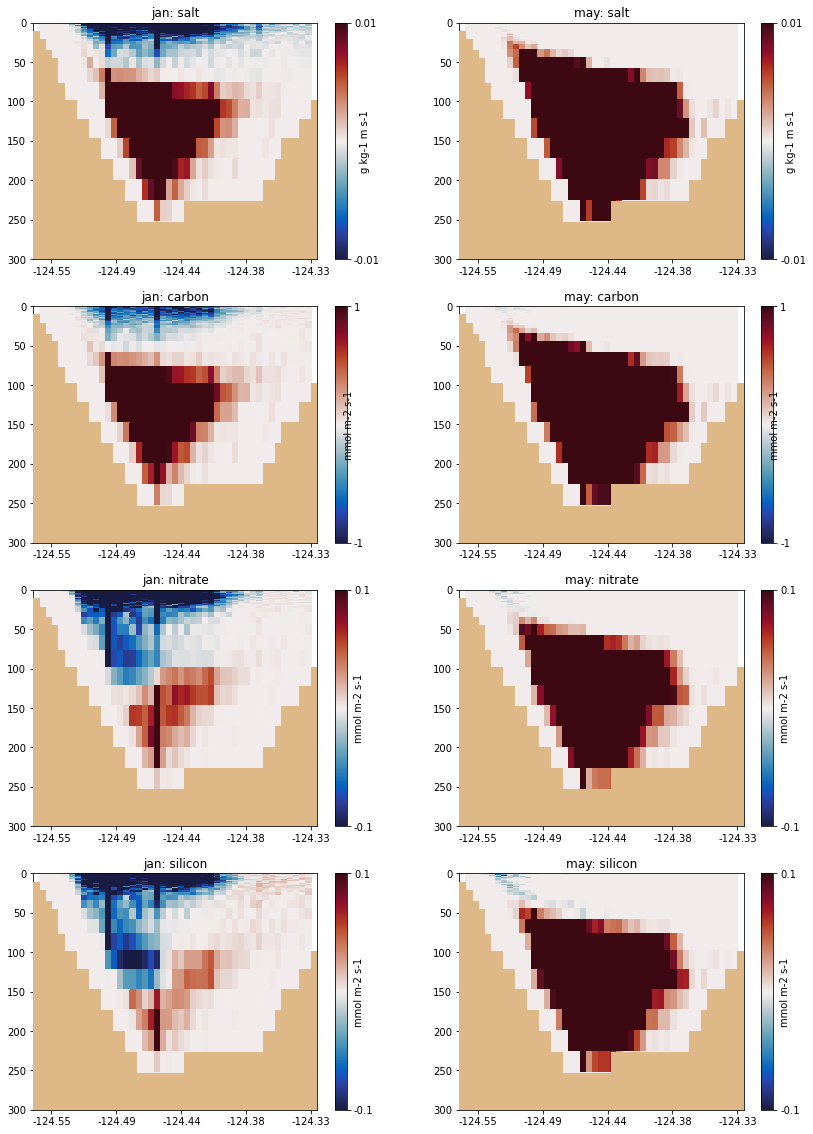

In [23]:
# now plt january and may for all four tracers
str_mo = ['jan', 'may']
fig, ax = plt.subplots(4, 2, figsize = (14, 20))
for i in range(len(str_mo)):
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01'+str_mo[i]+'18/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)

    tracername = 'salt'
    JRTracerFluxCS_delta(tracername, 18, 63, 377, 300, ax[0,i], str_mo[i]+": "+tracername)

    tracername = 'carbon'
    JRTracerFluxCS_delta(tracername, 18, 63, 377, 300, ax[1,i], str_mo[i]+": "+tracername)

    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01'+str_mo[i]+'18/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)

    tracername = 'nitrate'
    JRTracerFluxCS_delta(tracername, 18, 63, 377, 300, ax[2,i], str_mo[i]+": "+tracername)

    tracername = 'silicon'
    JRTracerFluxCS_delta(tracername, 18, 63, 377, 300, ax[3,i], str_mo[i]+": "+tracername)

### lets get % of flow to each CS month to month for the full 5 years

In [24]:
def get_transport(mydata, section, starttime, endtime):
    time = endtime-starttime+1
    transports = (mydata.final_transp[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)])/time
    sumTr = sum(transports)
    
    transports = (mydata.final_transp[(mydata.final_section != 0) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)])/time
    totalTr = sum(transports)
    return sumTr, totalTr

In [25]:
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
starttime = 1
endtime = 720
time = endtime-starttime+1

sec_nums = [2,3,4,5,6]
admiralty = np.array([])
deception = np.array([])
rosario = np.array([])
sanjuan = np.array([])
haro = np.array([])
sections = [admiralty, deception, rosario, sanjuan, haro]
all_total = np.array([])

#2016 and 2017
year = [16,17]

for num in year:
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan'+str(num)+'/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(12):
        for j in range(len(sec_nums)):
            temp, totalT = get_transport(mydata, sec_nums[j], starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
            sections[j] = np.append(sections[j],temp)
        all_total = np.append(all_total, totalT)

#2019 and 2018 (both done month by month)
year = [18,19]
for num in year:
    for i in range(len(str_mo)):
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01'+str_mo[i]+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        time = mydata.init_t[-1]

        totalT = sum((mydata.final_transp[(mydata.final_section != 0) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)])/time)

        for j in range(len(sec_nums)):
            temp = sum((mydata.final_transp[(mydata.final_section==sec_nums[j]) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)])/time)
            sections[j] = np.append(sections[j],temp)       
        all_total = np.append(all_total, totalT)
            
#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
for i in range(12):
    for j in range(len(sec_nums)):
        temp, totalT = get_transport(mydata, sec_nums[j], starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
        sections[j] = np.append(sections[j],temp)
    all_total = np.append(all_total, totalT)

In [26]:
admiralty = sections[0]
deception = sections[1]
rosario = sections[2]
sanjuan = sections[3]
haro = sections[4]

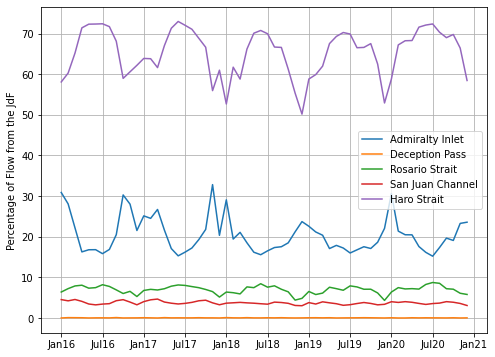

In [27]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot(admiralty/all_total*100, label="Admiralty Inlet")
ax.plot(deception/all_total*100, label="Deception Pass")
ax.plot(rosario/all_total*100, label="Rosario Strait")
ax.plot(sanjuan/all_total*100, label="San Juan Channel")
ax.plot(haro/all_total*100, label="Haro Strait")
ax.legend()
ax.set_ylabel("Percentage of Flow from the JdF")
# ax.set_xlabel("Month")
ax.set_xticks(np.arange(0,61,6))
ax.set_xticklabels(['Jan16','Jul16','Jan17','Jul17','Jan18','Jul18','Jan19','Jul19','Jan20','Jul20','Jan21'])
ax.grid()

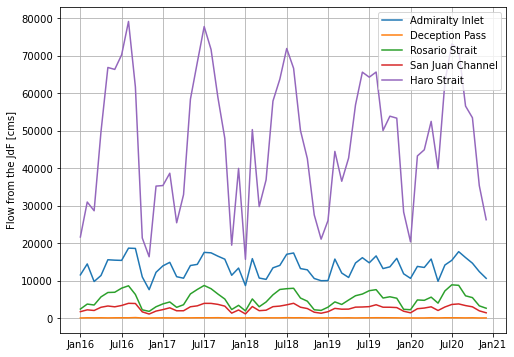

In [28]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot(admiralty, label="Admiralty Inlet")
ax.plot(deception, label="Deception Pass")
ax.plot(rosario, label="Rosario Strait")
ax.plot(sanjuan, label="San Juan Channel")
ax.plot(haro, label="Haro Strait")
ax.legend()
ax.set_ylabel("Flow from the JdF [cms]")
# ax.set_xlabel("Month")
ax.set_xticks(np.arange(0,61,6))
ax.set_xticklabels(['Jan16','Jul16','Jan17','Jul17','Jan18','Jul18','Jan19','Jul19','Jan20','Jul20','Jan21'])
ax.grid()

In [29]:
# residence time of SoG and Puget based on volume of these basins?
V_pug = 168*(1000**3) # km3 converted to m3, easily found online
V_sog = 222000*28000*155 #couldn't find quickly nad decided not to bother, based on average width, length, and depth from Thomson 1981

(-1.0, 61.0)

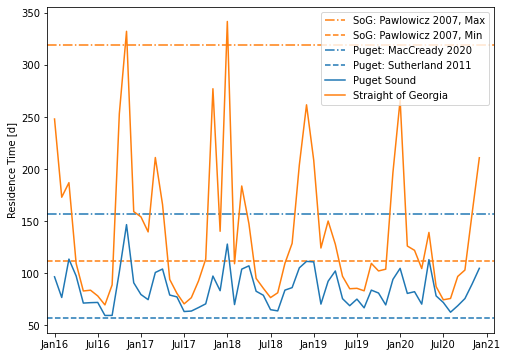

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot([-1,61],[319,319], c='tab:orange',  linestyle='-.',label="SoG: Pawlowicz 2007, Max")
ax.plot([-1,61],[112,112], c='tab:orange', linestyle='--',label="SoG: Pawlowicz 2007, Min")
ax.plot([-1,61],[157,157], c='tab:blue', linestyle='-.',label="Puget: MacCready 2020")
ax.plot([-1,61],[57,57], c='tab:blue', linestyle='--',label="Puget: Sutherland 2011")
ax.plot((V_pug/(admiralty+deception))/(60*60*42), c='tab:blue',label="Puget Sound")
ax.plot((V_sog/(haro+sanjuan+rosario))/(60*60*42), c='tab:orange',label="Straight of Georgia")
ax.legend()
ax.set_ylabel("Residence Time [d]")
# ax.set_xlabel("Month")
ax.set_xticks(np.arange(0,61,6))
ax.set_xticklabels(['Jan16','Jul16','Jan17','Jul17','Jan18','Jul18','Jan19','Jul19','Jan20','Jul20','Jan21'])
# ax.grid()
ax.set_xlim([-1,61])

not wild compared to previous estiamtions of the residence time of the SoG (112-319 in Pawlowicz 2007) or Puget (57 in Sutherland 2011 and 157 in MacCready 2020)